# Rainfalls in Navarcles: Visualisation and Forecasting

Navarcles is a village in the Bages region (province of Barcelona, autonomous community of Catalonia, Spain). It is situated at the eastern end of the Pla de Bages, on the left bank of the Llobregat River, where it meets the Calders River, approximately 11 km from the regional capital, Manresa.

Since 2008, Navarcles has had a meteorological station, with historical data available on the City Hall's [website](https://www.navarcles.cat/el-municipi/informacio-meteorologica/resums-climatologics). No publicly accessible data is available prior to 2008. However, there is privately collected rainfall data, manually recorded from 1995 to 2024. Visualization of this data along with the development of a predictive model for next month’s rainfall, may be of interest to the village and the wider region.

**Goal**
- develop a user-friendly dashboard to visualize precipitation in Navarcles, with potential for future publication on the City Hall website
- build a machine learning (ML) model to predict monthly rainfall

**Data description**  
1. *Manually collected daily precipitation data in Navarcles.<br>*
Rainfalls were measured manually by a resident of Navarcles using a pluviometer (unit: mm, equivalent to l/m²). Data was recorded in a notebook from 1995 until April 2020 and has been entered into an Excel spreadsheet since May 2020. The dataset includes daily rainfall amounts (mm) and notes on snow events.
2. *Catalan Daily Temperature and Precipitation dataset (CADTEP) for Manresa.<br>*
The Climatology Area of the Meteorological Service of Catalonia provides the [CADTEP database](https://www.meteo.cat/wpweb/climatologia/dades-i-productes-climatics/series-climatiques-des-de-1950/), which consist of continuous, homogeneous, and publicly accessible climate series at daily and monthly resolutions since 1950. Daily data for Manresa was obtained as a `.txt` file, containing following fields:
- `ANY`: year
- `MES`: month	
- `DIA`: day
- `PPT`: daily accumulated precipitation in mm
- `TX`: daily maximum temperature in ºC
- `TN`: daily minimum temperature in ºC
- `INS`: insolation in h
3. *Data from Navarcles City Hall's website.*  
From 2008 historical data is available on the City Hall's [website](https://www.navarcles.cat/el-municipi/informacio-meteorologica/resums-climatologics). Monthly data with daily resolution for Navarcles was obtained as a `.txt` file, containing following fields:
- `DIA`: day
- `TEMP MIT`: daily mean temperature
- `MAX`: daily maximum temperature in ºC
- `HORA`: time of MAX
- `MIN`: daily minimum temperature in ºC
- `HORA`: time of MIX
- `GRAUS DIA CAL.`:
- `GRAUS DIA FRED`:
- `PLUJ`: daily accumulated precipitation in mm
- `VEL VENT MIT`: daily mean wind speed
- `MAX`: daily maximum wind speed in km/h
- `HORA`: time of MAX
- `DIR DOM`: dominant wind direction

In [15]:
# import libraries 
import os
import re
import warnings

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from phik.report import correlation_report, plot_correlation_matrix
from pmdarima import auto_arima
from prophet import Prophet
from pyod.models.knn import KNN

warnings.filterwarnings("ignore")

In [16]:
# display settings
# font sizes
params = {'figure.titlesize': 18,
          'axes.titlesize':   16,
          'axes.labelsize':   14,
          'font.size': 14,
          'legend.fontsize':  12,
          'xtick.labelsize':  12,
          'ytick.labelsize':  12}
plt.rcParams.update(params)

# customized color palette
palette = ['#769FB6', '#ECA400', '#B26E63', '#7FB069', '#68C3D4']
sns.set_palette(palette)

# plt.style.use
sns.set_style("darkgrid")

In [17]:
# set random state
RANDOM_STATE = 42

# set data path
PATH_data = os.path.join('..', 'data')

## Data Loading and Preprocessing
### Navarcles: Manually Collected Data
Manually collected data originally recorded in the notebook was transferred to an Excel file.
In the Excel file missing values are indicated with "NA", while empty cells represent days without rainfall.

In [18]:
# read excel file
FILENAME = 'navarcles_manual_1995-2024.xlsx'
data = pd.read_excel(os.path.join(PATH_data, FILENAME), na_values=["NA"], keep_default_na=False)
data

Unnamed: 0 1995 1996 1997  1998 1999 2000 2001 2002 2003  ... 2015 2016  \
0   2020-01-01                    7    6              2  NaN  ...             
1   2020-01-02              9                         3  NaN  ...         2   
2   2020-01-03             24                         2  NaN  ...             
3   2020-01-04                                           NaN  ...             
4   2020-01-05         3                                 NaN  ...             
..         ...  ...  ...  ...   ...  ...  ...  ...  ...  ...  ...  ...  ...   
361 2020-12-27                            NaN       NaN       ...       NaN   
362 2020-12-28                            NaN       NaN       ...       NaN   
363 2020-12-29                            NaN       NaN       ...       NaN   
364 2020-12-30    3                       NaN       NaN       ...       NaN   
365 2020-12-31        14       12.5       NaN       NaN       ...       NaN   

    2017 2018 2019 2020 2021 2022 2023 2024  
0    NaN                                     
1    NaN                                     
2    NaN                                     
3    NaN                                     
4    NaN                        1       4.5  
..   ...  ...  ...  ...  ...  ...  ...  ...  
361    2                                     
362                                          
363                                          
364                                          
365                                          

[366 rows x 31 columns]

In [19]:
# replace empty cells with 0 
data = data.replace('',0).rename(columns={data.columns[0]: 'date'})

# correct date format
data["date"] = data['date'].dt.strftime("%m-%d")
data

date  1995  1996  1997  1998  1999  2000  2001  2002  2003  ...  2015  \
0    01-01   0.0   0.0   0.0   7.0   6.0   0.0     0   2.0   NaN  ...     0   
1    01-02   0.0   0.0   9.0   0.0   0.0   0.0     0   3.0   NaN  ...     0   
2    01-03   0.0   0.0  24.0   0.0   0.0   0.0     0   2.0   NaN  ...     0   
3    01-04   0.0   0.0   0.0   0.0   0.0   0.0     0   0.0   NaN  ...     0   
4    01-05   0.0   3.0   0.0   0.0   0.0   0.0     0   0.0   NaN  ...     0   
..     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
361  12-27   0.0   0.0   0.0   0.0   0.0   NaN     0   NaN   0.0  ...     0   
362  12-28   0.0   0.0   0.0   0.0   0.0   NaN     0   NaN   0.0  ...     0   
363  12-29   0.0   0.0   0.0   0.0   0.0   NaN     0   NaN   0.0  ...     0   
364  12-30   3.0   0.0   0.0   0.0   0.0   NaN     0   NaN   0.0  ...     0   
365  12-31   0.0  14.0   0.0  12.5   0.0   NaN     0   NaN   0.0  ...     0   

     2016  2017  2018  2019  2020  2021  2022  2023  2024  
0     0.0   NaN   0.0     0   0.0   0.0   0.0   0.0   0.0  
1     2.0   NaN   0.0     0   0.0   0.0   0.0   0.0   0.0  
2     0.0   NaN   0.0     0   0.0   0.0   0.0   0.0   0.0  
3     0.0   NaN   0.0     0   0.0   0.0   0.0   0.0   0.0  
4     0.0   NaN   0.0     0   0.0   0.0   1.0   0.0   4.5  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
361   NaN   2.0   0.0     0   0.0   0.0   0.0   0.0   0.0  
362   NaN   0.0   0.0     0   0.0   0.0   0.0   0.0   0.0  
363   NaN   0.0   0.0     0   0.0   0.0   0.0   0.0   0.0  
364   NaN   0.0   0.0     0   0.0   0.0   0.0   0.0   0.0  
365   NaN   0.0   0.0     0   0.0   0.0   0.0   0.0   0.0  

[366 rows x 31 columns]

#### Reshaping the data
Let’s convert the data into a long format, where each row represents a day between 1995 and 2024 with its corresponding rainfall value.

In [20]:
# reshape data to long format
df = data.melt(id_vars=["date"], var_name="year", value_name="rainfall")

In [21]:
# create full date column
df["full_date"] = pd.to_datetime(
    df["year"].astype(str) + "-" + df["date"], 
    format="%Y-%m-%d",
    errors="coerce"
)
df

date  year  rainfall  full_date
0      01-01  1995       0.0 1995-01-01
1      01-02  1995       0.0 1995-01-02
2      01-03  1995       0.0 1995-01-03
3      01-04  1995       0.0 1995-01-04
4      01-05  1995       0.0 1995-01-05
...      ...   ...       ...        ...
10975  12-27  2024       0.0 2024-12-27
10976  12-28  2024       0.0 2024-12-28
10977  12-29  2024       0.0 2024-12-29
10978  12-30  2024       0.0 2024-12-30
10979  12-31  2024       0.0 2024-12-31

[10980 rows x 4 columns]

In [22]:
# check for Nans in full date
df.query('full_date.isna()')

date  year  rainfall full_date
59     02-29  1995       0.0       NaT
791    02-29  1997       0.0       NaT
1157   02-29  1998       0.0       NaT
1523   02-29  1999       0.0       NaT
2255   02-29  2001       0.0       NaT
2621   02-29  2002       0.0       NaT
2987   02-29  2003       NaN       NaT
3719   02-29  2005       0.0       NaT
4085   02-29  2006       0.0       NaT
4451   02-29  2007       0.0       NaT
5183   02-29  2009       0.0       NaT
5549   02-29  2010       0.0       NaT
5915   02-29  2011       0.0       NaT
6647   02-29  2013       0.0       NaT
7013   02-29  2014       0.0       NaT
7379   02-29  2015       0.0       NaT
8111   02-29  2017       NaN       NaT
8477   02-29  2018       0.0       NaT
8843   02-29  2019       0.0       NaT
9575   02-29  2021       0.0       NaT
9941   02-29  2022       0.0       NaT
10307  02-29  2023       0.0       NaT

In the wide format, February 29 was included for all years, resulting in NaN values for non-leap years.

In [23]:
# drop February 29 for non-leap years
df = df.dropna(subset=["full_date"]).reset_index(drop=True)           

The excessive columns `day` and `year` can be deleted and `full_date` column let´s use as index. We know that our data has NaNs, let´s also check their percentage.
The redundant `day` and `year` columns can be removed, and the `full_date` column will be used as the index.

In [24]:
# drop day and year columns, set full date as index
df = (df.drop(columns=["date", "year"])
      .set_index('full_date')
     )

#### Missing values
During the transfer of data from the notebooks to the Excel file, it was noticed that there were gaps in the data. Let’s calculate the percentage of these missing values.

In [25]:
print(df.info())
print('\n\n\033[1mNumber of NaN\033[0m')
print(f'{df["rainfall"].isna().sum()}')
print('\033[1mPercentage of NaN\033[0m')
print(f'{df["rainfall"].isna().mean():.2%}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10958 entries, 1995-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rainfall  10280 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB
None


Number of NaN
678
Percentage of NaN
6.19%


In [26]:
# years and months with Nans
res = df[df['rainfall'].isna()].fillna(1)
res.groupby([res.index.year, res.index.month]).sum()

rainfall
full_date full_date          
1996      2              29.0
          3              31.0
          5              31.0
2000      11             30.0
          12             31.0
2002      11             10.0
          12             31.0
2003      1              31.0
          2              28.0
          3              31.0
2016      11             30.0
          12             31.0
2017      1              31.0
          2              28.0
          3              31.0
          4              30.0
          5              31.0
          6              30.0
          7              31.0
          8              31.0
          9              30.0
          10             31.0
          11             30.0

There is no data for 678 days — almost two years out of the total 30-year period. Notably, most of 2017 is missing. Dropping these records is not an option, as it would disrupt the continuity of the time series. To address the missing values, external sources can be considered.

Let’s verify whether the data is organized in chronological order.

In [27]:
# check for monotonicity
if df.index.is_monotonic_increasing:
    print('The data is arranged in chronological order.')
else:
    print('Dates are repeated or out of order.')

The data is arranged in chronological order.


### Navarcles: Data from City Hall website
From 2008 historical data is available on the City Hall's [website](https://www.navarcles.cat/el-municipi/informacio-meteorologica/resums-climatologics).

In [28]:
DATA_DIR = os.path.join(PATH_data, 'navarcles_cityhall_2008-2024')

In [29]:
# create dataframe for cityhall data
df_ajunt = pd.DataFrame(columns=('full_date', 'rainfall'))

# read all .txt files and merge them in dataframe
for file_name in os.listdir(DATA_DIR):
    
    # find year-month info in the filname
    match = re.search(r'(\d{6})\.txt$', file_name.lower())
    if not match:
        print(f"Skipping file {file_name}: no date match")
        continue
    year_month = match.group(1)
    
    try:
        df_rain = pd.read_csv(DATA_DIR+'/'+file_name, sep="\s+", header=6, skipfooter=10, engine='python', encoding='ISO-8859-1')
    except Exception as e:
        print(f"Cannot read file {file_name}: {e}")
        continue
            
    df_rain = df_rain.drop(0)[['DIA', 'PLUJ']].rename(columns={'DIA': 'day', 'PLUJ': 'rainfall'})
 
    # create full date adding day number to extracted year-month info
    df_rain['full_date'] = pd.to_datetime(year_month + df_rain['day'], format='%Y%m%d')
    
    df_rain = df_rain.drop('day', axis=1)
    
    df_ajunt = pd.concat([df_ajunt, df_rain])

Skipping file .DS_Store: no date match
Cannot read file meteo_navarcles_201509.txt: No columns to parse from file


In [30]:
# organize data chronologically
df_ajunt = df_ajunt.sort_values(by='full_date').set_index('full_date')

In [31]:
# add missing dates
df_ajunt = pd.DataFrame(index = pd.Index(pd.date_range(start='2008-01-01', end='2024-12-31', freq='D'), name='full_date')).join(df_ajunt)
df_ajunt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6210 entries, 2008-01-01 to 2024-12-31
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rainfall  5903 non-null   float64
dtypes: float64(1)
memory usage: 226.1 KB


In [32]:
# check for monotonicity
if df_ajunt.index.is_monotonic_increasing:
    print('The data is arranged in chronological order.')
else:
    print('Dates are repeated or out of order.')

The data is arranged in chronological order.


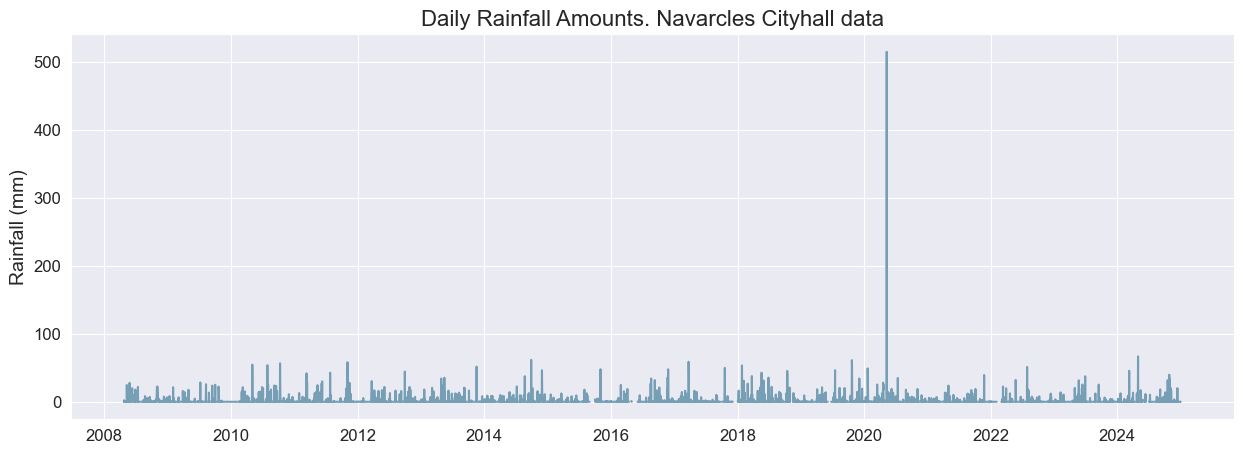

In [33]:
# TimeSeries plot
plt.figure(figsize=(15,5))
plt.plot(df_ajunt)
plt.title('Daily Rainfall Amounts. Navarcles Cityhall data')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.show()

In [34]:
df_ajunt['2020-05':'2020-05']

rainfall
full_date           
2020-05-01       0.0
2020-05-02       0.0
2020-05-03       0.0
2020-05-04       0.0
2020-05-05       0.0
2020-05-06       0.0
2020-05-07       0.0
2020-05-08       0.0
2020-05-09       0.0
2020-05-10     514.6
2020-05-11      12.9
2020-05-12       4.0
2020-05-13       0.4
2020-05-14      15.6
2020-05-15       0.0
2020-05-16      11.8
2020-05-17       0.2
2020-05-18       0.0
2020-05-19       0.0
2020-05-20       0.0
2020-05-21       0.0
2020-05-22       0.0
2020-05-23       0.0
2020-05-24       0.0
2020-05-25       0.0
2020-05-26       0.0
2020-05-27       0.0
2020-05-28       0.0
2020-05-29       9.6
2020-05-30       0.0
2020-05-31       0.0

The input data for "2020-05-10:2020-05-12" is strange, let's replace it with NaN.

In [35]:
df_ajunt.loc['2020-05-10':'2020-05-12', :] = np.nan

In [36]:
df_ajunt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6210 entries, 2008-01-01 to 2024-12-31
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rainfall  5900 non-null   float64
dtypes: float64(1)
memory usage: 226.1 KB


In [37]:
# save DataFrame to a .csv file
df_ajunt.to_csv('navarcles_cityhall_2008-2024.csv')

In [38]:
df_ajunt.value_counts().sort_index().head(15)

rainfall
0.0         3982
0.2          771
0.4          156
0.6           65
0.8           52
1.0           51
1.2           44
1.4           31
1.6           32
1.8           25
2.0           21
2.2           17
2.4           19
2.6           21
2.8           16
Name: count, dtype: int64

Precision of the data collected manually and the city hall data is different. We will round the data to an accuracy of 0.5. and we will not take into account rainfalls <0.5 mm (==0).

In [39]:
df_ajunt[df_ajunt.rainfall<=0.5] = 0

df_ajunt['rainfall'] = np.where(df_ajunt['rainfall'] % 1 > 0.5, 
                                np.ceil(df_ajunt['rainfall']), 
                                np.where(df_ajunt['rainfall'] % 1 < 0.5, 
                                         np.floor(df_ajunt['rainfall']), 
                                         df_ajunt['rainfall']))

In [40]:
df_ajunt.value_counts().sort_index().head(15)

rainfall
0.0         4909
1.0          243
2.0          114
3.0           88
4.0           81
5.0           52
6.0           40
7.0           44
8.0           29
9.0           26
10.0          25
11.0          19
12.0          25
13.0          18
14.0          16
Name: count, dtype: int64

#### Missing values

In [41]:
print(df_ajunt.info())
print('\n\n\033[1mNumber of NaN\033[0m')
print(f'{df_ajunt["rainfall"].isna().sum()}')
print('\033[1mPercentage of NaN\033[0m')
print(f'{df_ajunt["rainfall"].isna().mean():.2%}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6210 entries, 2008-01-01 to 2024-12-31
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rainfall  5900 non-null   float64
dtypes: float64(1)
memory usage: 226.1 KB
None


Number of NaN
310
Percentage of NaN
4.99%


In [42]:
# years and months with Nans
res = df_ajunt[df_ajunt['rainfall'].isna()].fillna(1)
res.groupby([res.index.year, res.index.month]).sum()

rainfall
full_date full_date          
2008      1              31.0
          2              29.0
          3              31.0
          4              21.0
          5               1.0
2015      9              30.0
2016      3               1.0
          4              12.0
          5              31.0
          6               1.0
2017      9               8.0
          12             27.0
2018      11             15.0
2019      6              18.0
2020      5               3.0
2022      2              24.0
          3               1.0
2024      5               7.0
          6              19.0

### Manresa: Data from CADTEP Database
One option for filling missing values is to use rainfall data from Manresa, a city located 11 km from Navarcles. Open-source data from the CADTEP database is available for Manresa and can be leveraged to fill these gaps

In [43]:
# read .txt
# read excel file
FILENAME = 'manresa_cadtep_1950-2023.txt'
data_manresa = pd.read_csv(os.path.join(PATH_data, FILENAME), sep="\s+", encoding = 'unicode_escape', header=11)
data_manresa

ANY  MES  DIA  PPT    TX   TN   INS
0      1950    1    1  0.6  11.1  4.3 -99.9
1      1950    1    2  0.0  10.5  0.8 -99.9
2      1950    1    3  0.0  12.7  0.8 -99.9
3      1950    1    4  0.0  11.8  3.8 -99.9
4      1950    1    5  0.0  13.9  0.8 -99.9
...     ...  ...  ...  ...   ...  ...   ...
27023  2023   12   27  0.0  15.1 -3.2   7.2
27024  2023   12   28  0.0   5.8 -4.1   0.2
27025  2023   12   29  0.0  11.0 -0.4   0.8
27026  2023   12   30  0.0  15.5 -0.3   7.3
27027  2023   12   31  0.0  13.6 -0.1   3.0

[27028 rows x 7 columns]

In [44]:
# rename columns
df_manresa = (data_manresa
              .set_axis(['year', 'month', 'day', 'rainfall', 't_max', 't_min', 'insolation'], axis=1)
              )

df_manresa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27028 entries, 0 to 27027
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        27028 non-null  int64  
 1   month       27028 non-null  int64  
 2   day         27028 non-null  int64  
 3   rainfall    27028 non-null  float64
 4   t_max       27028 non-null  float64
 5   t_min       27028 non-null  float64
 6   insolation  27028 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 1.4 MB


In [45]:
# create full date column
df_manresa['full_date'] = pd.to_datetime(
    df_manresa['year'].astype(str) + '-' + 
    df_manresa['month'].astype(str) + '-'+ 
    df_manresa['day'].astype(str)
)
df_manresa

year  month  day  rainfall  t_max  t_min  insolation  full_date
0      1950      1    1       0.6   11.1    4.3       -99.9 1950-01-01
1      1950      1    2       0.0   10.5    0.8       -99.9 1950-01-02
2      1950      1    3       0.0   12.7    0.8       -99.9 1950-01-03
3      1950      1    4       0.0   11.8    3.8       -99.9 1950-01-04
4      1950      1    5       0.0   13.9    0.8       -99.9 1950-01-05
...     ...    ...  ...       ...    ...    ...         ...        ...
27023  2023     12   27       0.0   15.1   -3.2         7.2 2023-12-27
27024  2023     12   28       0.0    5.8   -4.1         0.2 2023-12-28
27025  2023     12   29       0.0   11.0   -0.4         0.8 2023-12-29
27026  2023     12   30       0.0   15.5   -0.3         7.3 2023-12-30
27027  2023     12   31       0.0   13.6   -0.1         3.0 2023-12-31

[27028 rows x 8 columns]

In [46]:
# drop redundant columns, set full date as index
df_manresa = (df_manresa.drop(columns=['year', 'month', 'day'])
              .set_index('full_date')
             )

Let's check which dates are available in the Manresa dataset and verify whether the data is monotonic.

In [47]:
print('Date range:', df_manresa.index.min(), ':', df_manresa.index.max())

# check for monotonicity
if df_manresa.index.is_monotonic_increasing:
    print('\nThe data is arranged in chronological order.')
else:
    print('\nDates are repeated or out of order.')

Date range: 1950-01-01 00:00:00 : 2023-12-31 00:00:00

The data is arranged in chronological order.


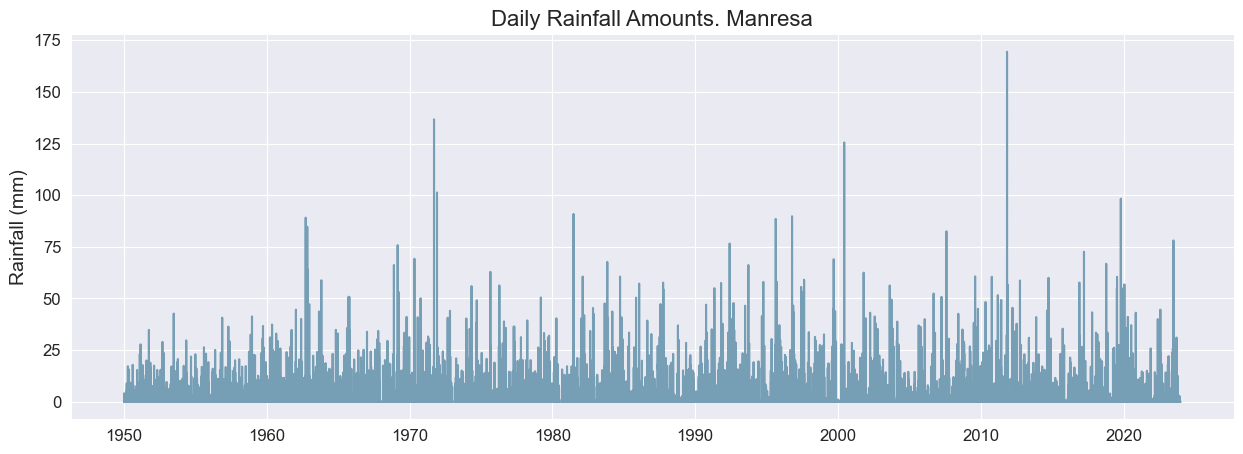

In [48]:
# TimeSeries plot
plt.figure(figsize=(15,5))
plt.plot(df_manresa.rainfall)
plt.title('Daily Rainfall Amounts. Manresa')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.show()

In [49]:
df_manresa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27028 entries, 1950-01-01 to 2023-12-31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rainfall    27028 non-null  float64
 1   t_max       27028 non-null  float64
 2   t_min       27028 non-null  float64
 3   insolation  27028 non-null  float64
dtypes: float64(4)
memory usage: 1.0 MB


We don't have data for 2024 in the Manresa dataset, but fortunately, the Manresa dataset covers the entire period with missing values in the Navarcles dataset. This will allow us to use the available data from Manresa to fill in the gaps in the Navarcles dataset for the missing dates.

In [50]:
df_manresa.rainfall.value_counts().sort_index().head(20)

rainfall
0.0    20501
0.1      462
0.2      388
0.3      261
0.4      224
0.5      203
0.6      165
0.7      128
0.8      148
0.9      183
1.0      132
1.1       72
1.2       85
1.3       80
1.4       95
1.5       90
1.6       70
1.7       68
1.8      122
1.9       48
Name: count, dtype: int64

In [51]:
df_manresa[df_manresa.rainfall < 0.5]['rainfall'] = 0

df_manresa['rainfall'] = np.where(df_manresa['rainfall'] % 1 > 0.5, 
                                np.ceil(df_manresa['rainfall']), 
                                np.where(df_manresa['rainfall'] % 1 < 0.5, 
                                         np.floor(df_manresa['rainfall']), 
                                         df_manresa['rainfall']))

In [52]:
df_manresa.rainfall.value_counts().sort_index().head(20)

rainfall
0.0    21836
0.5      203
1.0     1088
1.5       90
2.0      619
2.5       60
3.0      414
3.5       34
4.0      320
4.5       62
5.0      226
5.5       32
6.0      209
6.5       17
7.0      197
7.5       13
8.0      151
8.5       15
9.0      136
9.5        5
Name: count, dtype: int64

### Comparison of Manresa and Navarcles
Before filling the NaN values in the Navarcles dataset with data from the Manresa dataset, let's compare the two datasets to ensure their compatibility and identify any potential differences. 

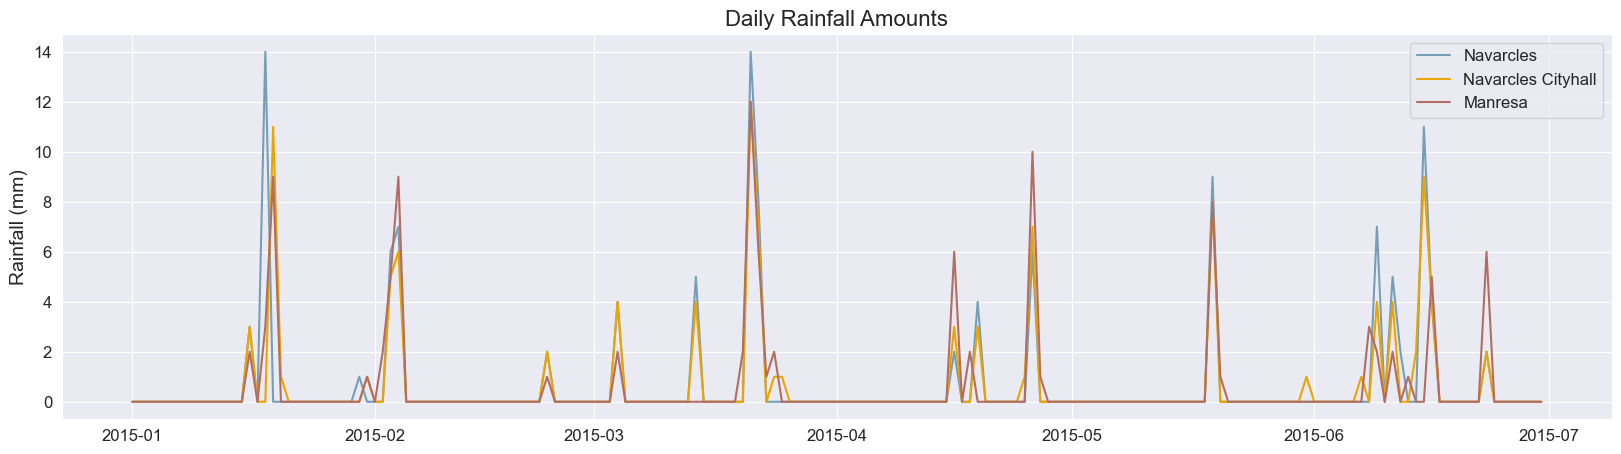

In [53]:
plt.figure(figsize=(20,5))
plt.plot(df['2015-01':'2015-06'], label='Navarcles')
plt.plot(df_ajunt[['rainfall']]['2015-01':'2015-06'], label='Navarcles Cityhall')
plt.plot(df_manresa[['rainfall']]['2015-01':'2015-06'], label='Manresa')
plt.legend()
plt.title('Daily Rainfall Amounts')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.show()

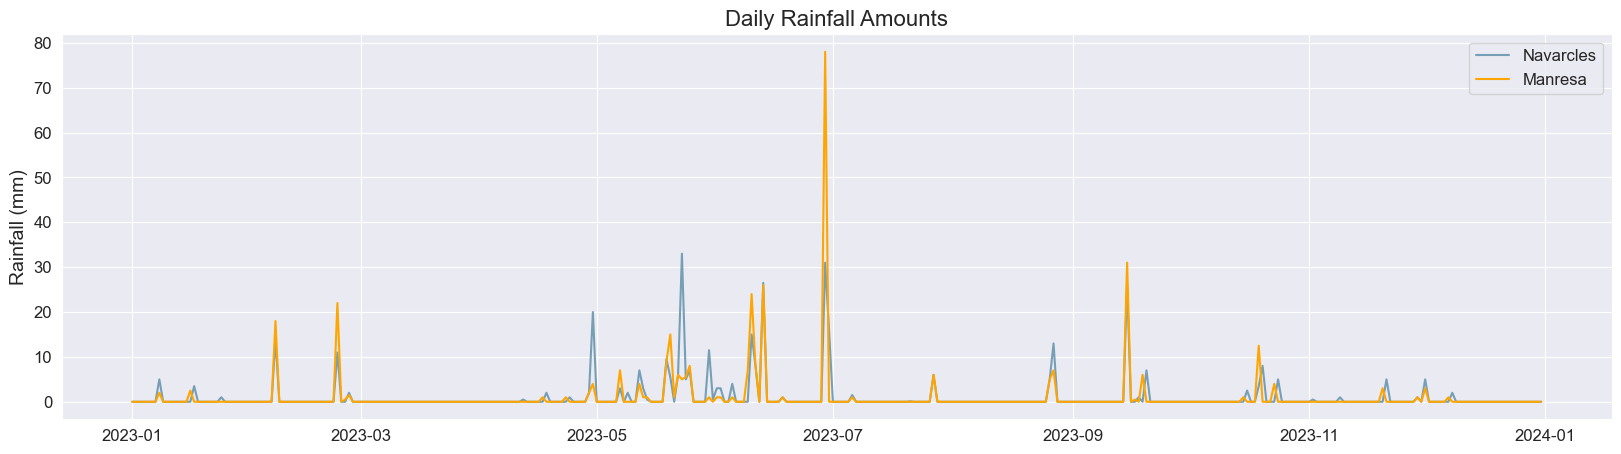

In [54]:
# TimeSeries plot
plt.figure(figsize=(20,5))
plt.plot(df['2023':'2023'], label='Navarcles')
plt.plot(df_manresa[['rainfall']]['2023':'2023'], label='Manresa', color='orange')
plt.legend()
plt.title('Daily Rainfall Amounts')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.show()

Upon reviewing data from different years, it can be observed that the rainfall data from Manresa and Navarcles are similar and largely coincide. To further validate this, we can compare the distributions and general statistics of both datasets.

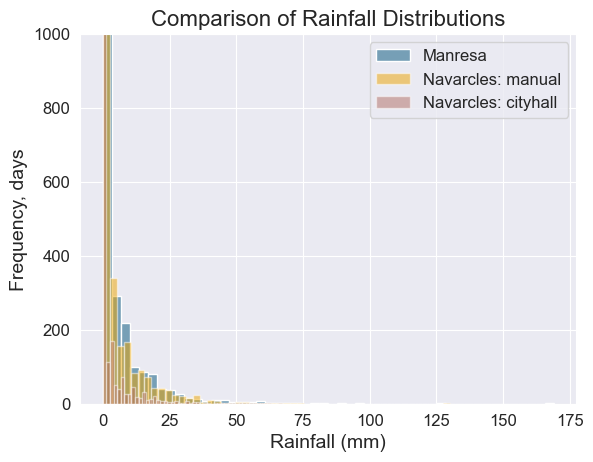

In [55]:
# distribution of rainfall amounts in Navarcles and Manresa
plt.hist(df_manresa[df_manresa.index.year>1994]['rainfall'], bins=50, label='Manresa')
plt.hist(df['rainfall'], bins=50, alpha=0.5,label='Navarcles: manual')
plt.hist(df_ajunt['rainfall'], bins=50, alpha=0.5, label='Navarcles: cityhall')

plt.title('Comparison of Rainfall Distributions')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency, days')
plt.legend()
plt.ylim(0, 1000)
plt.show()

In [56]:
# descriptive statistics for daily data
print('Manresa')
print(df_manresa[(df_manresa['rainfall'] >0) & (df_manresa.index.year>1994)]['rainfall'].describe())

print('\nNavarcles')
print(df[df['rainfall'] >0]['rainfall'].describe())

print('\nNavarcles: cityhall')
print(df_ajunt[df_ajunt['rainfall'] >0]['rainfall'].describe())

Manresa
count    1781.000000
mean        8.608647
std        12.284359
min         0.500000
25%         1.500000
50%         4.000000
75%        11.000000
max       169.000000
Name: rainfall, dtype: float64

Navarcles
count    1412.000000
mean       11.059278
std        11.635744
min         0.100000
25%         3.000000
50%         7.000000
75%        15.000000
max       130.000000
Name: rainfall, dtype: float64

Navarcles: cityhall
count    991.000000
mean       8.125126
std       10.264506
min        1.000000
25%        2.000000
50%        4.000000
75%       11.000000
max       67.000000
Name: rainfall, dtype: float64


In [57]:
# descriptive statistics for monthly data
print('Manresa')
print(df_manresa[(df_manresa.index.year>1994)][['rainfall']].resample('MS').sum().describe())

print('\nNavarcles')
print(df.resample('MS').sum().describe())

Manresa
         rainfall
count  348.000000
mean    44.057471
std     41.876477
min      0.000000
25%     12.000000
50%     34.500000
75%     62.500000
max    299.000000

Navarcles
         rainfall
count  360.000000
mean    43.376944
std     40.189177
min      0.000000
25%     10.250000
50%     33.500000
75%     65.250000
max    206.000000


While there are some differences between the datasets, the overall range of values is similar. When looking at monthly accumulated data, the values coincide more closely, suggesting that the datasets are compatible for filling in the missing values in Navarcles with data from Manresa.

**Conclusion**:<br>
Given the similarities in the data, especially in terms of the monthly accumulated values, we can proceed with filling the missing values in the Navarcles dataset using the data from the Manresa dataset.

### Filling missing values

Given the similarities in the data, we decided to fill the missing values in the manually collected data using:
- first - data from Navarcles City Hall's website
- second - data from the Manresa dataset.

This approach should help maintain the continuity and integrity of the time series without introducing significant biases.

In [58]:
df['data_source'] = np.where(df.isna(), 'cityhall', 'manual')

In [59]:
# fill NaN with values from Navarcles Cityhall dataset
df = df.fillna(df_ajunt)
print(df.info())
print('\n\033[1mPercentage of NaN\033[0m')
print(f'{df["rainfall"].isna().mean():.2%}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10958 entries, 1995-01-01 to 2024-12-31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rainfall     10667 non-null  float64
 1   data_source  10958 non-null  object 
dtypes: float64(1), object(1)
memory usage: 514.9+ KB
None

Percentage of NaN
2.66%


In [60]:
df.loc[df.rainfall.isna(), 'data_source'] = 'manresa'

In [61]:
# fill rest NaN with values from Manresa dataset
df['rainfall'] = df['rainfall'].fillna(df_manresa['rainfall'])
print(df.info())
print('\n\033[1mPercentage of NaN\033[0m')
print(f'{df["rainfall"].isna().mean():.2%}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10958 entries, 1995-01-01 to 2024-12-31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rainfall     10958 non-null  float64
 1   data_source  10958 non-null  object 
dtypes: float64(1), object(1)
memory usage: 514.9+ KB
None

Percentage of NaN
0.00%


In [62]:
# check one of periods with Nan
df_manresa.loc['1996-02':'1996-03', 'rainfall'].sum() == df.loc['1996-02':'1996-03', 'rainfall'].sum()

True

### Save Dataframe for Visualization
To visualize the data in Tableau, let's save the processed DataFrame as a `.csv` file. Additionally, we will include available snow-related data that was recorded in the notebooks.

In [63]:
# notes about snow
snow = {'2001-12-14': [1, 'Neva tot el dia, 35 cm'],
        '2004-02-16': [1, 'Pluja i neu, 27 litres'],
        '2004-02-17': [1, 'Pluja i neu, 27 litres'],
        '2006-01-27': [1, 'Pluja i neu'],
        '2006-01-28': [1, 'Continua nevant, 20 cm'],
        '2009-12-21': [1, 'Pluja i neu'],
        '2009-12-22': [1, 'Pluja i neu'],
        '2010-03-08': [1, 'Nevada de 30 cm'],
        '2012-02-02': [1, '11 litres en forma de neu'],
        '2018-02-28': [1, 'Nevada de 10 cm'],
        '2021-01-09': [1, 'Enfarinada'],
        '2023-01-24': [1, 'Enfarinada']}

In [64]:
# dictionary into a DataFrame
df_snow = pd.DataFrame.from_dict(snow, orient='index', columns=['snow', 'comment'])

# index to datetime
df_snow.index = pd.to_datetime(df_snow.index)
df_snow

snow                    comment
2001-12-14     1     Neva tot el dia, 35 cm
2004-02-16     1     Pluja i neu, 27 litres
2004-02-17     1     Pluja i neu, 27 litres
2006-01-27     1                Pluja i neu
2006-01-28     1     Continua nevant, 20 cm
2009-12-21     1                Pluja i neu
2009-12-22     1                Pluja i neu
2010-03-08     1            Nevada de 30 cm
2012-02-02     1  11 litres en forma de neu
2018-02-28     1            Nevada de 10 cm
2021-01-09     1                 Enfarinada
2023-01-24     1                 Enfarinada

In [65]:
# add snow info to df
df_viz = df.merge(df_snow, how='left', left_index=True, right_index=True)

For entries with no snow data, we will use "0" in the column `snow` and an empty string in the `comment` column.

In [66]:
# 0 for days without snow
df_viz['snow'] = df_viz['snow'].fillna(0)

# empty string for "no comment"
df_viz['comment'] = df_viz['comment'].fillna('')

In [67]:
df_viz['2017-09':'2017-09']

rainfall data_source  snow comment
full_date                                     
2017-09-01       0.0    cityhall   0.0        
2017-09-02       0.0    cityhall   0.0        
2017-09-03       0.0    cityhall   0.0        
2017-09-04       8.0    cityhall   0.0        
2017-09-05       0.0    cityhall   0.0        
2017-09-06       0.0    cityhall   0.0        
2017-09-07       0.0    cityhall   0.0        
2017-09-08       0.0    cityhall   0.0        
2017-09-09       0.0    cityhall   0.0        
2017-09-10       0.0    cityhall   0.0        
2017-09-11       0.0    cityhall   0.0        
2017-09-12       0.0    cityhall   0.0        
2017-09-13       0.0    cityhall   0.0        
2017-09-14       0.0    cityhall   0.0        
2017-09-15       0.0    cityhall   0.0        
2017-09-16       0.0    cityhall   0.0        
2017-09-17       0.0    cityhall   0.0        
2017-09-18       0.0    cityhall   0.0        
2017-09-19       0.0    cityhall   0.0        
2017-09-20       0.0    cityhall   0.0        
2017-09-21       0.0    cityhall   0.0        
2017-09-22       0.0    cityhall   0.0        
2017-09-23       0.0     manresa   0.0        
2017-09-24       0.0     manresa   0.0        
2017-09-25       4.0     manresa   0.0        
2017-09-26       0.0     manresa   0.0        
2017-09-27       0.0     manresa   0.0        
2017-09-28       0.0     manresa   0.0        
2017-09-29       0.0     manresa   0.0        
2017-09-30       2.0     manresa   0.0

In [70]:
# save DataFrame to a .csv file
df_viz.to_csv(os.path.join(PATH_data, 'data_navarcles_1995-2024.csv'))

### Resampling
For prediction, we will use monthly data. Let’s resample the daily rainfall data, summarizing it into monthly totals.

In [133]:
# resampling, rainfall per month (Navarcles)
df_month = df[['rainfall']].resample('MS').sum()
df_month.head()

rainfall
full_date           
1995-01-01       7.0
1995-02-01       5.5
1995-03-01       0.0
1995-04-01      35.0
1995-05-01     100.0

For Manresa dataset let's also save temperature and insolation info, calculating median values.

In [134]:
# resampling, data per month (Manresa)
df_manresa_month = df_manresa.resample('MS').agg({'rainfall': 'sum', 
                                                  't_max': 'median', 't_min': 'median', 
                                                  'insolation': 'median'})
df_manresa_month.head()

rainfall  t_max  t_min  insolation
full_date                                     
1950-01-01       6.0   11.6  -0.10       -99.9
1950-02-01       5.0   14.4   2.40       -99.9
1950-03-01      29.0   18.5   2.70       -99.9
1950-04-01      44.0   18.0   5.05       -99.9
1950-05-01      50.5   23.6  10.60       -99.9

## EDA

Let's plot the resulting time series.

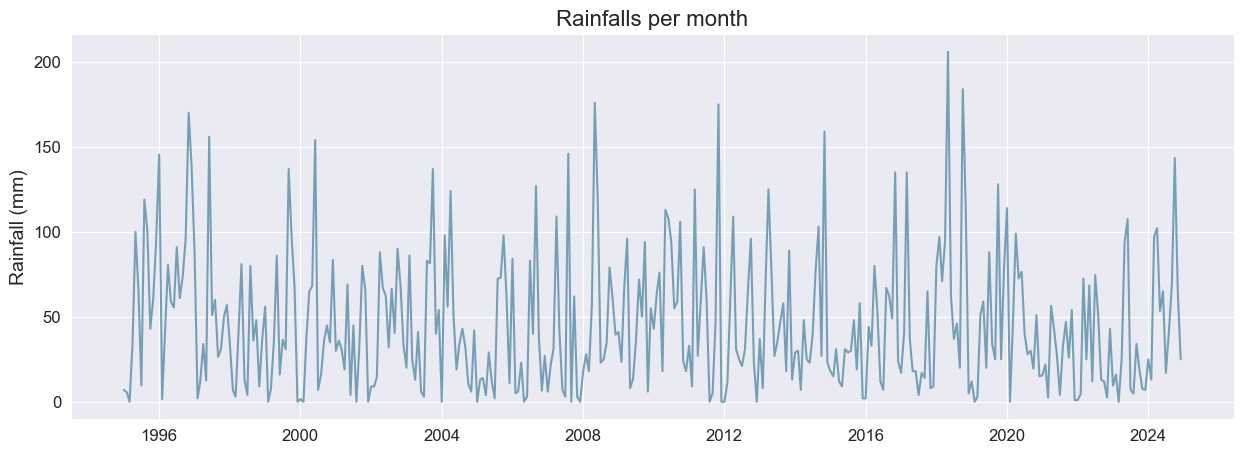

In [148]:
# TimeSeries plot
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_month, legend=False)
plt.title('Rainfalls per month')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.show()

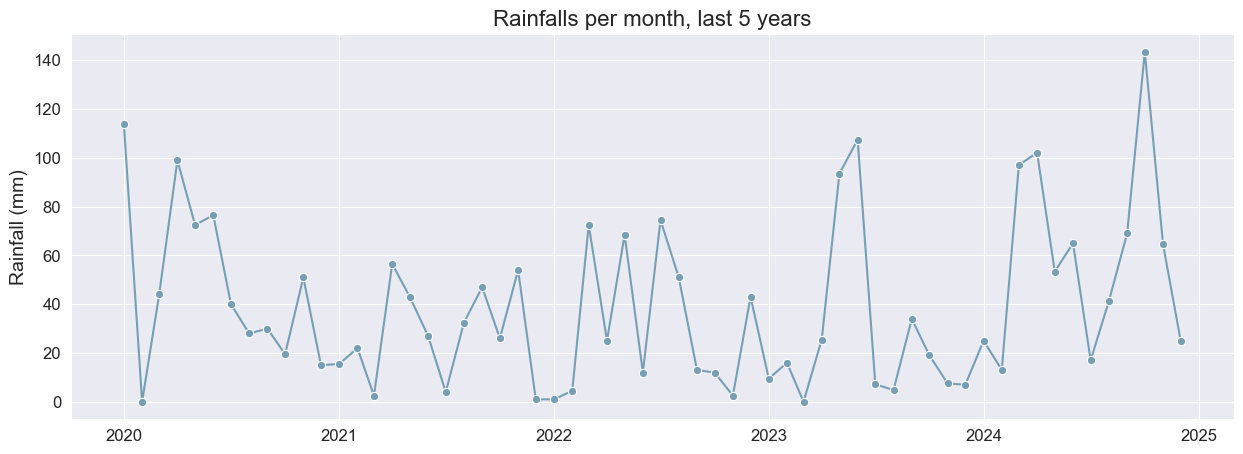

In [149]:
# TimeSeries plot for last 5 years
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_month['2020':'2024'], marker='o', legend=False)
plt.title('Rainfalls per month, last 5 years')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.show()

The data shows significant variations in monthly rainfall amounts, ranging from 0 to over 200 mm. While one might expect to see annual seasonality (for example, higher precipitation in May and October), no clear seasonal pattern is immediately apparent. However, it can be observed that peaks tend to occur in the spring and autumn months.

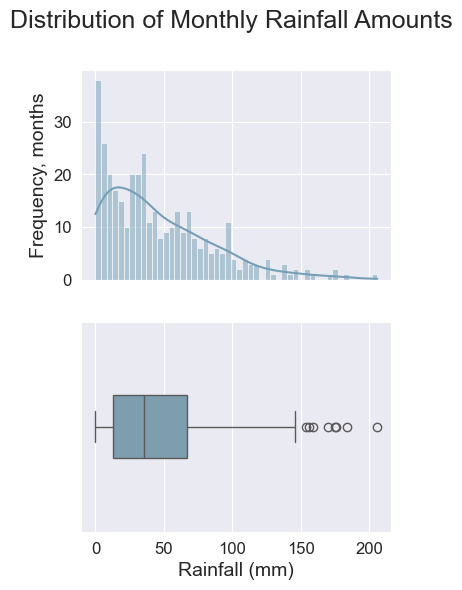

rainfall
count  360.000000
mean    45.889444
std     39.561974
min      0.000000
25%     13.000000
50%     35.700000
75%     67.250000
max    206.000000

In [50]:
# distribution of rainfall amounts
fig, axs = plt.subplots(2, 1, figsize=(4, 6))
fig.suptitle('Distribution of Monthly Rainfall Amounts')

# histogram
(sns.histplot(data=df_month, kde=True, ax=axs[0], bins=50, legend=False)
   .set(xlabel=None, xticklabels=[], ylabel='Frequency, months')
)

# boxplot
(sns.boxplot(data=df_month, ax=axs[1], width=0.3, orient='h')
    .set(yticklabels=[], xlabel='Rainfall (mm)')
)
plt.show()

#descriptive statistics
df_month.describe()

There are many months with little to no rainfalls, as well as a few isolated instances where total monthly rainfall exceeds 150 mm. In most cases, however, the monthly rainfall amount does not exceed 70 mm, and in approximately half of the months, it is no more than 36 mm.

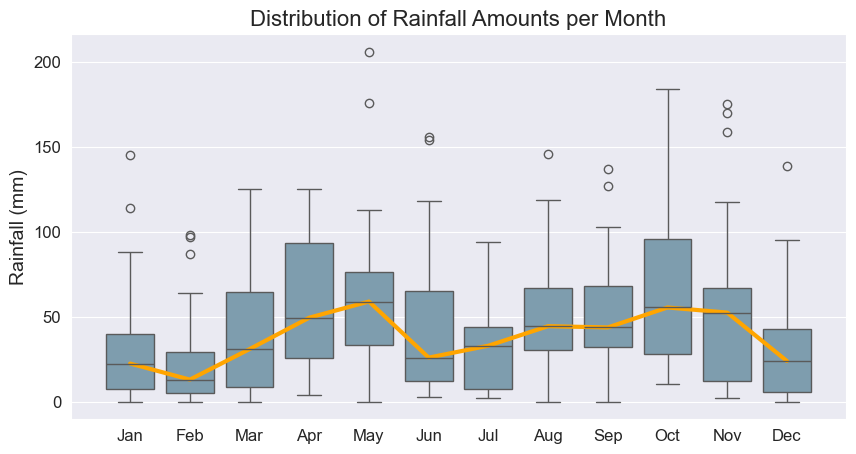

In [51]:
# rainfall distribution per month
plt.figure(figsize=(10,5))
sns.boxplot(data=df_month, x=df_month.index.strftime('%b'), y='rainfall')
sns.lineplot(df_month.groupby(df_month.index.month-1)['rainfall'].median(), color='orange', linewidth=3)
plt.title('Distribution of Rainfall Amounts per Month')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.show()

In [52]:
# descriptive statistics for each month
df_month.groupby(df_month.index.month).describe()

rainfall                                                          
             count       mean        std   min     25%    50%     75%    max
full_date                                                                   
1             30.0  33.020000  36.203947   0.0   7.500  22.50  40.000  145.5
2             30.0  23.560000  28.148628   0.0   5.125  13.05  29.500   98.0
3             30.0  38.196667  33.542947   0.0   8.625  31.00  64.375  125.0
4             30.0  57.556667  37.043066   4.0  25.875  49.50  93.250  125.0
5             30.0  62.203333  45.340022   0.0  33.500  59.00  76.625  206.0
6             30.0  46.780000  44.945871   3.0  12.250  26.00  65.000  156.0
7             30.0  34.036667  28.623182   2.0   7.500  33.00  43.750   94.0
8             30.0  48.913333  32.947657   0.0  30.250  44.50  66.875  146.0
9             30.0  51.943333  33.150125   0.0  32.250  43.75  68.250  137.0
10            30.0  67.126667  44.706537  10.5  28.000  55.50  96.000  184.0
11            30.0  56.086667  49.219135   2.5  12.500  52.50  66.750  175.0
12            30.0  31.250000  33.472601   0.0   5.500  24.00  42.750  139.0

All months show a fairly large spread in monthly rainfall amounts, with nearly every month having "outliers". While there is some indication of annual seasonality, with higher rainfalls in the spring and autumn, the seasonal pattern is not very pronounced. The months with the highest median values are May, October, and November. These months also tend to have more instances of high total rainfall amounts and a greater spread of values. February is the driest and most stable month. October stands out as the only month where the minimum monthly rainfall did not fall below 10 mm.

We can also see which data is considered outliers using the K-Nearest Neighbours method.

In [53]:
# outlier detection, K-Nearest Neighbors 
model_knn = KNN()
estimator_knn = model_knn.fit_predict(df_month)

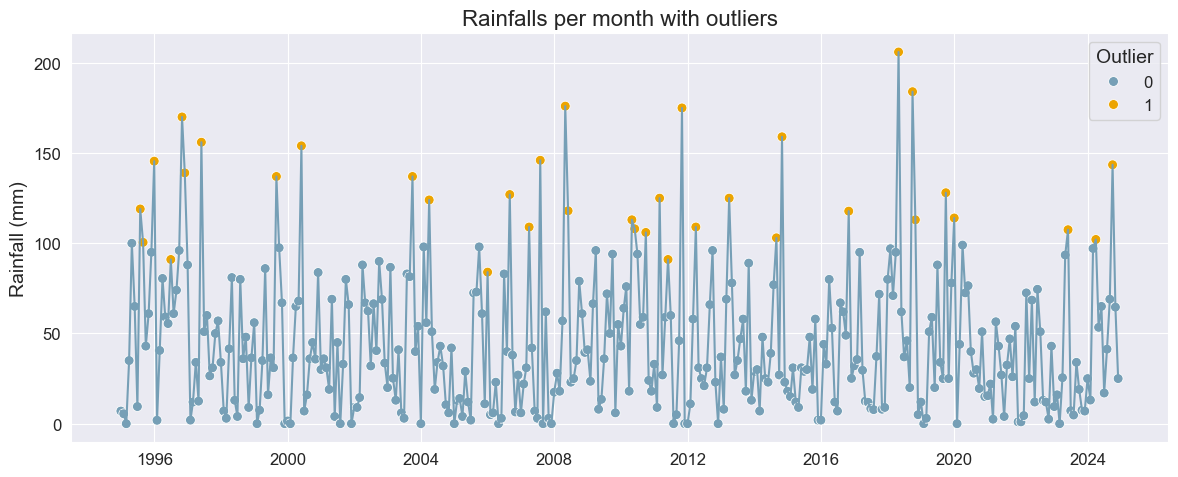

In [54]:
# plot outliers
plt.figure(figsize=(12,5))
sns.lineplot(data=df_month, legend=False)
sns.scatterplot(data=df_month, y='rainfall', x=df_month.index, s=50, hue=estimator_knn)

plt.title('Rainfalls per month with outliers')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.legend(title='Outlier')
plt.tight_layout()
plt.show()

**Conclusion**:<br>
There is no overall trend in the data, but there is likely some form of annual seasonality. For each month, there is a large spread of values (standard deviation ranging from 28 to 50 mm). "Outliers" are frequent — almost every month has instances where total monthly precipitation exceeds 100 mm (the average rainfall amount typically does not exceed 50 mm). In the case of monthly precipitation, these "outliers" are natural occurrences and should not be replaced or removed.

Before building ML models for time series prediction, let's investigate the intrinsic dynamics of the data:
- **Stationarity**: time series with trends or seasonality are not stationary. Many ML models for time series prediction (such as SARIMA) assume that the data is stationary. Ensuring stationarity will allow for more accurate predictions.
- **Autocorrelation Analysis**: plotting the autocorrelation function (ACF) and partial autocorrelation function (PACF) helps identify potential lag relationships between data points. This visual analysis provides insights for determining appropriate autoregressive (AR) and moving average (MA) terms for the model.
- **Seasonal Decomposition**: decomposing the time series into trend, seasonal, and residual components can reveal hidden patterns and help us better understand the seasonality in the data.

### Stationarity

Analyzing rainfall amounts using moving average and STD can help identify short-term and long-term trends. 

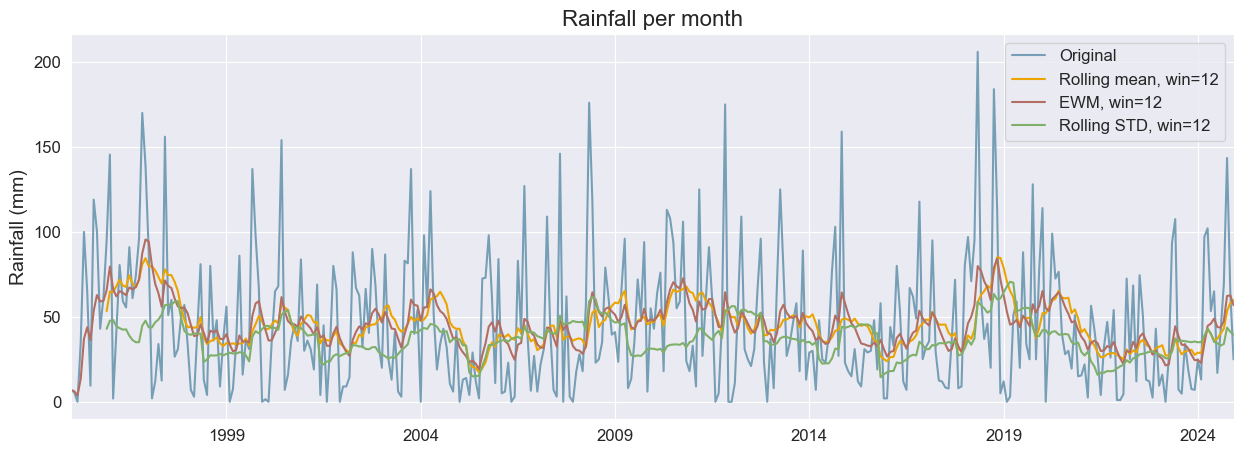

In [55]:
df_plot = df_month.copy()

# rolling mean, window size=6m
df_plot['mean'] = df_plot['rainfall'].rolling(12).mean()

# exponentially weighted moving average
df_plot['ewm'] = df_plot['rainfall'].ewm(span=12).mean()

# rolling sd, window size=6m
df_plot['std'] = df_plot['rainfall'].rolling(12).std()

# plot data, rolling mean and sd
df_plot.plot(figsize=(15, 5))

plt.title('Rainfall per month')
plt.ylabel('Rainfall (mm)')
plt.legend(['Original', 
            'Rolling mean, win=12',
            'EWM, win=12', 
            'Rolling STD, win=12'])
plt.xlabel(None)
plt.show()

The mean and standard deviation do not show any clear trend, and the spread of their values remains relatively constant over time. Based on this observation, we can assume that the data is stationary.

To confirm this, let's apply the augmented Dickey-Fuller Test, a statistical test commonly used to determine whether a time series is stationary.

In [56]:
# augmented Dickey-Fuller test
adf_test = adfuller(df_month['rainfall'])

print(f'ADF Statistic: {adf_test[0]:.2f}, p-value: {adf_test[1]}')
if adf_test[1] > 0.05:
    print("Data is non-stationary")
else:
    print("Data is stationary")

# remove seasonality
adf_test = adfuller(df_month.diff(12).dropna())
print('\nSeasonal differencing (lag=12 months)')
print(f'ADF Statistic: {adf_test[0]:.2f}, p-value: {adf_test[1]}')
if adf_test[1] > 0.05:
    print("Data is non-stationary")
else:
    print("Data is stationary")

ADF Statistic: -15.63, p-value: 1.6966264846974422e-28
Data is stationary

Seasonal differencing (lag=12 months)
ADF Statistic: -8.35, p-value: 3.0623327078928513e-13
Data is stationary


The ADF test p-value of 1.69e-28 is very small, indicating that the monthly rainfall data is stationary, even before applying any transformations like differencing.

After applying seasonal differencing (with a lag of 12 months), the ADF test for the differenced time series yields a p-value of 3.06e-13, which is also very small. This confirms that the differenced time series is also stationary.

### Seasonal Decomposition

Let's investigate seasonality using time serie decomposition into trend, seasonality, and residual (error) components.

In [57]:
# decomposition of Time Series, seasonality and trend
decomposed = seasonal_decompose(df_month)

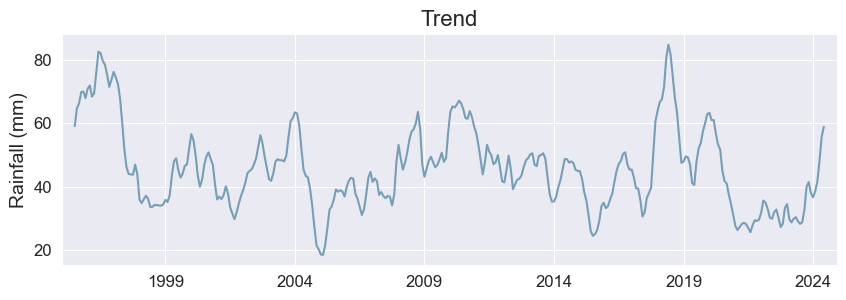

In [58]:
# plot trend
decomposed.trend.plot(figsize=(10, 3))
plt.title('Trend')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.show()

Monthly rainfall does not exhibit trend pattern, but several peaks are noticeable. The periods corresponding to these peaks can be further investigated to see patterns that may be contributing to these anomalies.

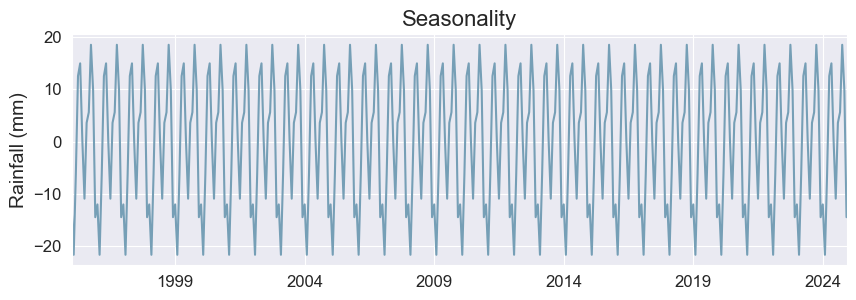

In [59]:
# plot seasonality
decomposed.seasonal.plot(figsize=(10, 3))
plt.title('Seasonality')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.show()

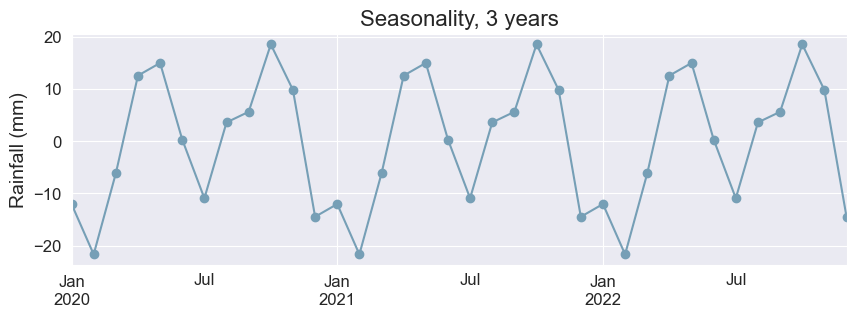

In [60]:
# plot seasonality
decomposed.seasonal['2020-01-01':'2022-12-31'].plot(style='-o', figsize=(10, 3))
plt.title('Seasonality, 3 years')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.show()

A clear annual seasonality is evident in the data, with increased rainfall observed during the autumn and spring months, and drier conditions during the winter months. This seasonal pattern provides valuable insights into the typical weather behavior in the region.

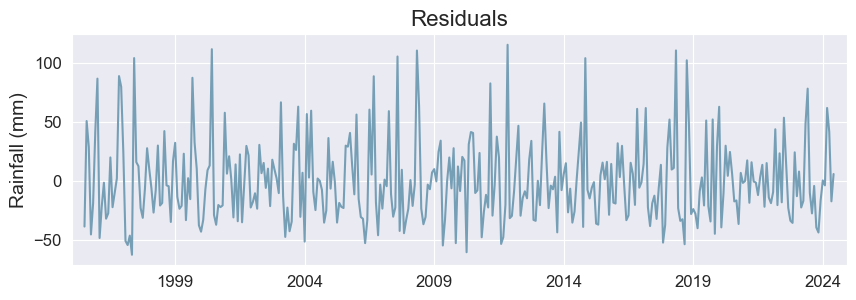

In [61]:
# plot residuals
decomposed.resid.plot(figsize=(10, 3))
plt.title('Residuals')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.show()

The residuals vary uniformly, with no discernible pattern, suggesting the residuals are random.

### ACF/PACF

The ACF calculates the correlation between a time series and its lagged values. The PACF measures the correlation between a lagged value and the current value of the time series, while accounting for the effect of the intermediate lags.

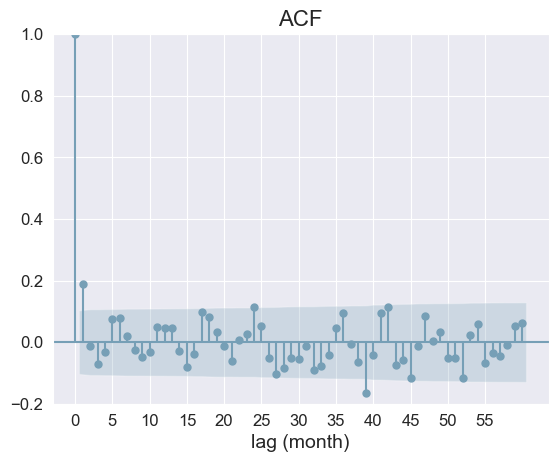

In [62]:
# plot autocorrelation function
plot_acf(df_month, lags=60)
plt.xticks(range(0, 60, 5))
plt.ylim(-0.2, 1)
plt.title('ACF')
plt.xlabel('lag (month)')
plt.show()

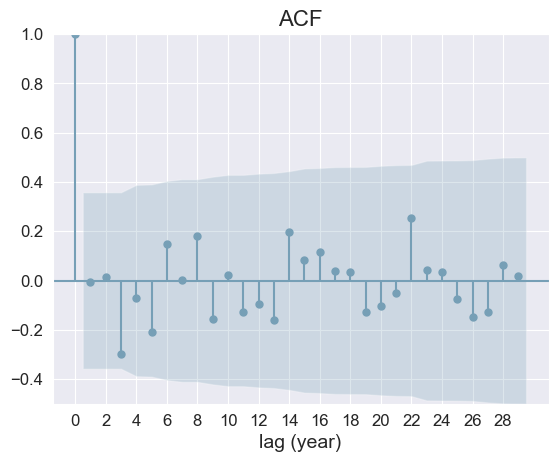

In [63]:
# resampling, rainfall per year
df_year = df.resample('1Y').sum()

# plot autocorrelation function
plot_acf(df_year, lags=29)
plt.xticks(range(0, 30, 2))
plt.ylim(-0.5, 1)
plt.title('ACF')
plt.xlabel('lag (year)')
plt.show()

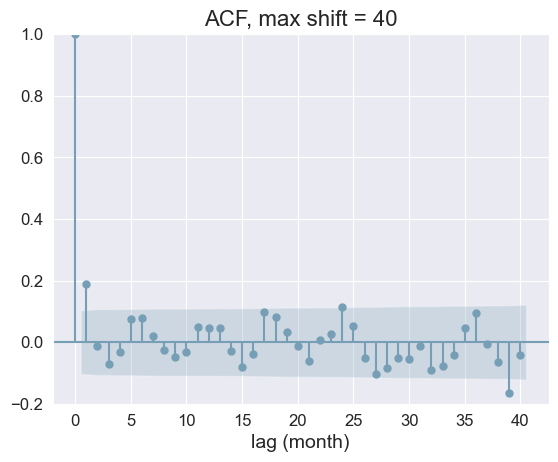

In [64]:
# plot autocorrelation function
plot_acf(df_month, lags=40)
plt.ylim(-0.2, 1)
plt.title('ACF, max shift = 40')
plt.xlabel('lag (month)')
plt.show()

In the ACF plot, no significant seasonality is observed, although small peaks at lags of 24 and 36 months may suggest a yearly seasonal effect. Significant correlation (0.2) occurs at lag 1, after which the correlation quickly decays. This indicates a short-term correlation at lag 1, along with a potential long-term seasonal effect. Based on this, we might consider using a first-order moving average (MA) model with **q = 1** to capture the short-term correlations and any potential long-term seasonal patterns.

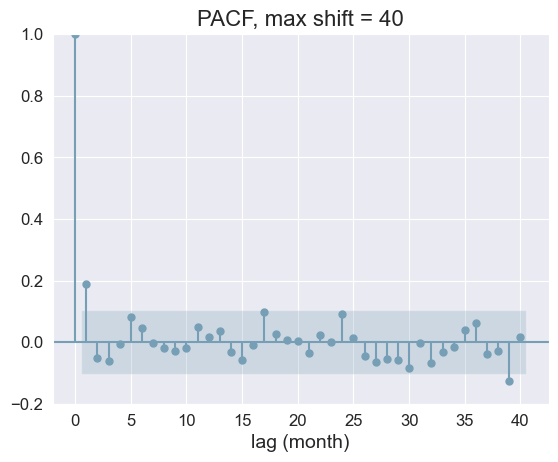

In [65]:
# plot partial autocorrelation function 
plot_pacf(df_month, lags=40)
plt.ylim(-0.2, 1)
plt.title('PACF, max shift = 40')
plt.xlabel('lag (month)')
plt.show()

Althought the stationarity analysis indicates that differencing is not required, let's anyway conduct analysis using the differenced series. We have seen that data is likely has year seasonality, so let's apply differencing with order 12 .

Although the stationarity analysis suggests that differencing may not be necessary, let's proceed with conducting an analysis using the differenced series for further confirmation. Since the data likely exhibits annual seasonality, we will apply seasonal differencing with an **order of 12** (corresponding to 12 months) to better capture any seasonal effects that might not be fully accounted for in the original series.

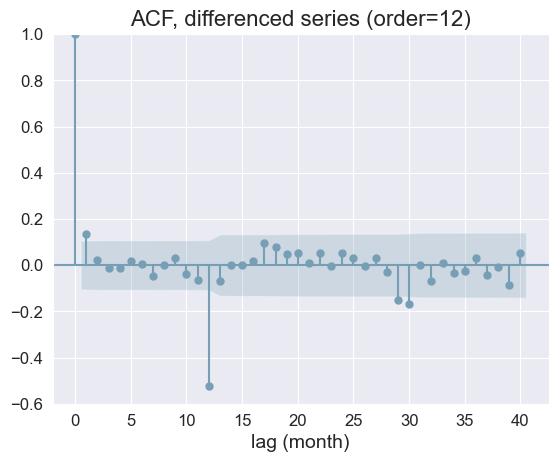

In [66]:
# seasonal differencing
df_seasonal_diff = df_month.diff(12).dropna()

# plot autocorrelation function
plot_acf(df_seasonal_diff, lags=40)
plt.ylim(-0.6, 1)
plt.xlabel('lag (month)')
plt.title('ACF, differenced series (order=12)')
plt.show()

In the Seasonal ACF, we observe significant correlation at lag 1 (0.17), a significant negative spike at lag 12 (-0.6), which corresponds to the seasonal period of 12 months, and further smaller negative correlations at lags 29 and 30 (both around -0.2).

The strong negative correlation at lag 12 suggests the presence of a seasonal MA component (Q = 1), indicating that a seasonal moving average term should be included in the model to account for the seasonal patterns in the data.

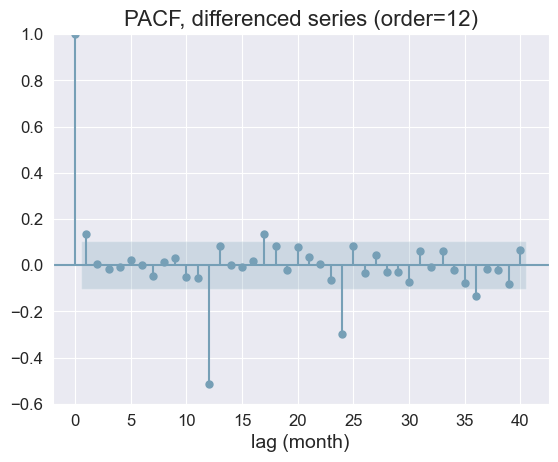

In [67]:
# plot partial autocorrelation function 
plot_pacf(df_seasonal_diff, lags=40)
plt.ylim(-0.6, 1)
plt.xlabel('lag (month)')
plt.title('PACF, differenced series (order=12)')
plt.show()

In the seasonal PACF, we observe significant correlation at lag 12 (-0.55), lag 24 (-0.3) and lag 36 (around -0.15), which corresponds to the seasonal period of 12 months. The strong negative correlation at lag 12 suggests the presence of a seasonal AR component (P = 1), indicating that a seasonal autoregressive term should be included in the model to capture the seasonal dynamics.

**Conclusions:**

**Initial Differencing Values**<br>
Original monthly rainfall data is already stationary, meaning d = 0 is a good starting point.<br>
After seasonal differencing (12 months), ACF/PACF still show significant seasonal correlations. D = 1 is a good choice because seasonality was still visible after first differencing.

The original monthly rainfall data is already stationary, meaning **d = 0** is a good starting point.
After seasonal differencing (12 months), the ACF/PACF still show significant seasonal correlations. Therefore, **D = 1** is a suitable choice.

**AR (p) and MA (q) Orders**<br>
- p = 1 (First-order AR, based on PACF peak at lag 1)
- q = 1 (First-order MA, based on ACF peak at lag 1)

**Seasonal AR (P) and Seasonal MA (Q) Orders**<br>
- P = 1 (Seasonal AR at lag 12)
- Q = 1 (Seasonal MA at lag 12)
- s = 12 (Periodicity of 12 months)

From the ACF/PACF and stationarity tests, a reasonable starting SARIMA model is:
SARIMA(p,d,q)(P,D,Q,s):
SARIMA(1,0,1)(1,1,1,12)

## Modeling
For the purpose of this project, we will test several popular models for time series forecasting, including:
- SARIMA: Seasonal AutoRegressive Integrated Moving Average model, which captures trends, seasonality, and autocorrelations in the data
- SARIMAX: A variant of SARIMA that includes exogenous variables, allowing for the inclusion of additional predictors
- Prophet: A forecasting tool developed by Facebook, particularly useful for data with strong seasonal patterns and missing values
- ElasticNet: A linear regression with combined regularization (Ridge and Lasso) to prevent overfitting
- CatBoost: high performance gradient boosting model that can handle categorical features well
- LightGBM: Another gradient boosting model

To assess the quality of these models, we will use the **Mean Absolute Error (MAE)** metric, which measures the average magnitude of errors in the forecasted values, providing a clear comparison of each model's performance.

### Train/Validation/Test split
The time series should be split into train, validation, and test sets in chronological order to preserve the temporal structure of the data.

For this project, we will save the last 3 years (10% of the data) as the test set, ensuring that the model will be evaluated on unseen data from the most recent period. The remaining data will be used for training and validation.

In [68]:
# train-test split, 10% as test set
train, test = train_test_split(df_month, test_size=0.1, shuffle=False)
print(f'Test size: {len(test)} months')
print('Train:', train.index.min(), ':', train.index.max())
print('Test:', test.index.min(), ':', test.index.max())

Test size: 36 months
Train: 1995-01-01 00:00:00 : 2021-12-01 00:00:00
Test: 2022-01-01 00:00:00 : 2024-12-01 00:00:00


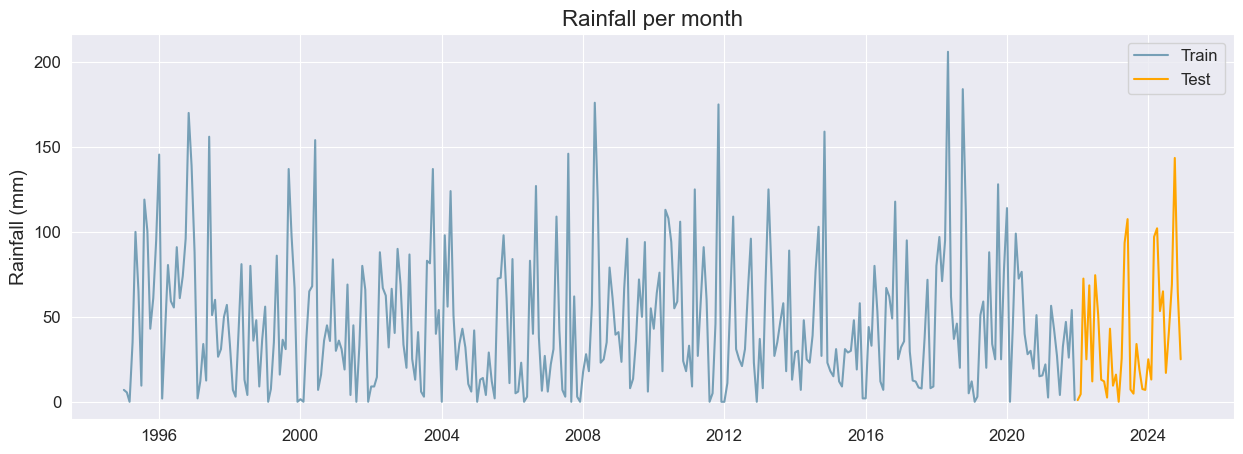

In [69]:
# plot train/test
plt.figure(figsize=(15,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color='orange')
plt.legend()
plt.title('Rainfall per month')
plt.ylabel('Rainfall (mm)')
plt.show()

We will use the increasing train window strategy to generate validation folds. The training set gradually increases with each fold, while the validation set remains the same size (matching the test period). This strategy is well-suited for time series forecasting, as it simulates a real-world scenario where more data becomes available over time.

In [70]:
# splits for cross-validation (8 folds)
tscv = TimeSeriesSplit(n_splits=8)

In [71]:
print('Train size : Test size')
for train_idx, val_idx in tscv.split(train):
    print(len(train_idx), ':', len(train.iloc[val_idx]))

Train size : Test size
36 : 36
72 : 36
108 : 36
144 : 36
180 : 36
216 : 36
252 : 36
288 : 36


### Constant Model

To establish a baseline for comparing the performance of more complex models, we can use the median model. This model simply "predicts" the median value of past observations for each month. For each month in the forecast period, we calculate the median of the historical values corresponding to that same month across previous years. This method provides a simple, constant model that does not account for trends or seasonality, allowing us to compare the performance of more sophisticated models against a basic benchmark.

In [72]:
# cross-validation
mae_list = []
for train_idx, val_idx in tscv.split(train):
    val_train, val_test = train.iloc[train_idx], train.iloc[val_idx]

    # median rainfall for each month of training data
    monthly_medians = val_train.groupby(val_train.index.month)['rainfall'].median()
    
    # calculate medians
    val_test['month'] = val_test.index.month
    val_test['forecast'] = val_test['month'].map(monthly_medians)
    
    # compute MAE
    mae = mean_absolute_error(val_test['rainfall'], val_test['forecast'])
    mae_list.append(mae)
    print(f'Fold MAE: {mae}')

# average MAE across folds
avg_mae = np.mean(mae_list)
sd_mae = np.std(mae_list)
print(f'\nMean monthly rainfall amount: {train["rainfall"].mean():.2f}')
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')

Fold MAE: 31.98055555555556
Fold MAE: 28.61944444444445
Fold MAE: 34.31944444444444
Fold MAE: 30.599999999999998
Fold MAE: 36.519444444444446
Fold MAE: 25.30972222222222
Fold MAE: 34.08888888888889
Fold MAE: 24.005555555555553

Mean monthly rainfall amount: 46.58
Average Cross-Validation MAE: 30.68, SD: 4.16


Let’s save the metric values and forecast data for future comparison. 

In [73]:
# characteristics for the pivot table
model_name = ['Constant model']
model_param = ['median per month']
models_forecast = pd.DataFrame(data={'rainfall': val_test['rainfall'], 'dummy': val_test['forecast']})
cv_mae = [round(avg_mae, 2)]
cv_sd = [round(sd_mae, 2)]

### SARIMA
We will first apply the SARIMA model using the analytically determined parameters: **SARIMA(1,0,1)(1,1,1,12)**.
These parameters were chosen based on stationarity tests, ACF/PACF analysis, and seasonal decomposition. This initial model will serve as a reference point before further tuning or exploring alternative models.

In [77]:
# cross-validation
mae_list = []
for train_idx, val_idx in tscv.split(train):
    val_train, val_test = train.iloc[train_idx], train.iloc[val_idx]
    
    # fit SARIMA model on train set
    sarima_model = SARIMAX(val_train, order=(1,0,1), seasonal_order=(1,1,1,12))
    result = sarima_model.fit(disp=False)
    
    # forecast validation period
    val_forecast = result.forecast(steps=len(val_test))
    
    # compute MAE
    mae = mean_absolute_error(val_test, val_forecast)
    mae_list.append(mae)
    print(f'Fold MAE: {mae}')

# average MAE across folds
avg_mae = np.mean(mae_list)
sd_mae = np.std(mae_list)
print(f'\nMean monthly rainfall amount: {train["rainfall"].mean():.2f}')
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')

Fold MAE: 51.90058406891772
Fold MAE: 28.4144997163978
Fold MAE: 32.886975616797244
Fold MAE: 29.506618398323198
Fold MAE: 34.33869497252752
Fold MAE: 25.88878167376934
Fold MAE: 33.76506200222345
Fold MAE: 25.67314271773841

Mean monthly rainfall amount: 46.58
Average Cross-Validation MAE: 32.80, SD: 7.88


In [78]:
# characteristics for the pivot table
model_name.append('SARIMA')
model_param.append('(1,0,1)(1,1,1)[12]')
models_forecast['sarima'] = val_forecast
cv_mae.append(round(avg_mae, 2))
cv_sd.append(round(sd_mae, 2))

This performance is worse than the median model, which achieved. Since the manually determined parameters did not yield better results, we will now use Auto-ARIMA to automatically select more optimal parameters and potentially improve the model’s forecasting accuracy.

### Auto-ARIMA

In [79]:
# fit AutoARIMA on training data
auto_model = auto_arima(train, seasonal=True, m=12,
                        stepwise=True, trace=True,
                        n_jobs=-1, suppress_warnings=True
                       )

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3308.921, Time=3.09 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3310.459, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3304.183, Time=0.95 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3303.880, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3588.119, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3302.193, Time=0.28 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=3303.810, Time=0.28 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=3300.877, Time=1.97 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=3301.142, Time=3.43 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=3301.525, Time=3.92 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3301.257, Time=1.92 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=3301.246, Time=2.86 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=3303.504, Time=5.39 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=3307.141, Time=1.63 sec
 ARIMA(1,0,1)(1,0,1

The Auto-ARIMA search identified the best model as: **ARIMA(0,0,1)(1,0,1)[12]**.

Compared to the original SARIMA(1,0,1)(1,1,1,12) model, the differences are:
- p = 0: No non-seasonal autoregressive terms (original: p = 1)
- D = 0: No seasonal differencing required (original: D = 1)

This suggests that the model benefits from a simpler non-seasonal structure and does not require seasonal differencing, possibly due to the data’s inherent stationarity and well-captured seasonality through other components.

In [80]:
# fit the SARIMA model with the selected orders
# cross-validation
mae_list = []
for train_idx, val_idx in tscv.split(train):
    val_train, val_test = train.iloc[train_idx], train.iloc[val_idx]
    
    # fit SARIMA model on train set
    sarima_model = SARIMAX(val_train, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
    result = sarima_model.fit(disp=False)
    
    # forecast validation period
    val_forecast = result.forecast(steps=len(val_test))

    val_forecast_tr = result.forecast(steps=len(val_train))
    # compute MAE
    mae = mean_absolute_error(val_test, val_forecast)
    mae_tr = mean_absolute_error(val_train, val_forecast_tr)
    mae_list.append(mae)
    print(f'Fold MAE: {mae}, Train {mae_tr}')

# average MAE across folds
avg_mae = np.mean(mae_list)
sd_mae = np.std(mae_list)
print(f'\nMean monthly rainfall amount: {train["rainfall"].mean():.2f}')
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')

Fold MAE: 28.380119343864077, Train 28.575890949618895
Fold MAE: 27.635788151207763, Train 27.424770183762192
Fold MAE: 32.25316259007673, Train 27.143570888516564
Fold MAE: 29.137334799390032, Train 28.49168446096532
Fold MAE: 34.66430301749337, Train 28.444451525221908
Fold MAE: 24.890560528319227, Train 29.449668446571195
Fold MAE: 32.83152774236536, Train 28.584495600547097
Fold MAE: 24.995622522993237, Train 29.33869960737291

Mean monthly rainfall amount: 46.58
Average Cross-Validation MAE: 29.35, SD: 3.38


Auto-ARIMA model performs slightly better than the median model (MAE: 30.68, SD: 4.16). However, the improvement is very small, suggesting that the complexity of Auto-ARIMA does not provide a substantial advantage over the simple median baseline for this dataset.
This indicates that:
- the data may be challenging to model due to high variability and frequent outliers.
- more advanced models or additional features might be needed to improve forecast accuracy

In [83]:
# characteristics for the pivot table
model_name.append('Auto-ARIMA')
model_param.append('(0,0,1)(1,0,1)[12]')
models_forecast['auto-arima'] = val_forecast
cv_mae.append(round(avg_mae, 2))
cv_sd.append(round(sd_mae, 2))

To ensure the ARIMA(0,0,1)(1,0,1)[12] model is appropriate (goodness-of-fit) and identify any remaining patterns or trends in the residuals, we performed residual diagnostics. Ideally, residuals should be uncorrelated and normally distributed with zero mean. If these conditions are not met, it is a good indication that it can be further improved.

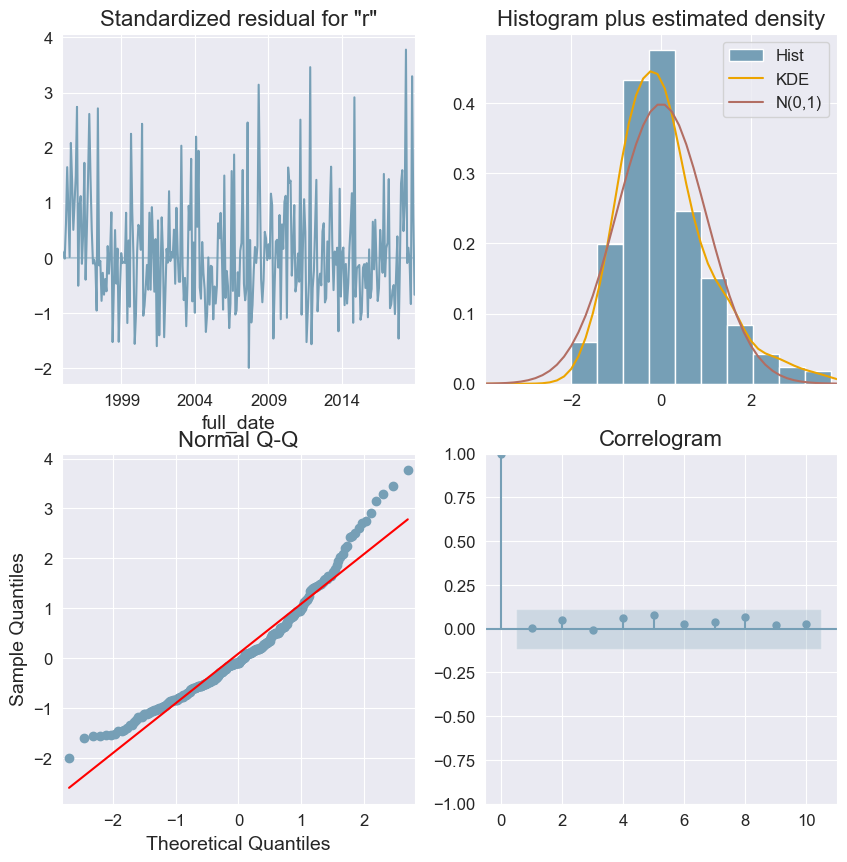

In [82]:
# plot diagnostics
result.plot_diagnostics(figsize=(10,10))
plt.show()

**Standardized residual**<br>
The Standardized residual is consistent across the graph (appear to be white noise), meaning that the data is close to being stationary.

This is confirmed by the **Correlogram**, which shows that the time series residuals have low correlation with lagged versions of itself.

**Histogram plus KDE estimate**: the KDE curve is similar to the normal distribution and data points are clustered more or less close to the **Normal Q-Q** line. This is a good indication that the residuals are normally distributed.

Although diagnostics are satisfactory, the forecast accuracy improvement over the baseline median model is minimal. To potentially enhance performance, we’ll explore other models, such as Prophet, known for effectively capturing seasonality and trend components in time series data.

### Prophet

In [67]:
# convert data to Prophet format
train_prophet = train[['rainfall']].reset_index().rename(columns={'full_date': 'ds', 'rainfall': 'y'})

In [68]:
# fit Prophet model
# cross-validation
mae_list = []
for train_idx, val_idx in tscv.split(train_prophet):
    val_train, val_test = train_prophet.iloc[train_idx], train_prophet.iloc[val_idx]
    
    # fit model on train set
    model = Prophet(yearly_seasonality=True, 
                    seasonality_mode="multiplicative"
                   )
    
    model.fit(val_train)
    
    # forecast future values for validation period
    future = val_test[['ds']]        # validation timestamps
    forecast = model.predict(future)

    # Compute MAE for this fold
    mae = mean_absolute_error(val_test['y'], forecast['yhat'])
    mae_list.append(mae)
    print(f'Fold MAE: {mae:.2f}')

# average MAE across folds
avg_mae = np.mean(mae_list)
sd_mae = np.std(mae_list)
print(f'\nMean monthly rainfall amount: {train["rainfall"].mean():.2f}')
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')

07:51:22 - cmdstanpy - INFO - Chain [1] start processing
07:51:22 - cmdstanpy - INFO - Chain [1] done processing
07:51:22 - cmdstanpy - INFO - Chain [1] start processing


Fold MAE: 31.25


07:51:23 - cmdstanpy - INFO - Chain [1] done processing
07:51:23 - cmdstanpy - INFO - Chain [1] start processing
07:51:23 - cmdstanpy - INFO - Chain [1] done processing


Fold MAE: 27.79
Fold MAE: 28.53


07:51:23 - cmdstanpy - INFO - Chain [1] start processing
07:51:23 - cmdstanpy - INFO - Chain [1] done processing
07:51:23 - cmdstanpy - INFO - Chain [1] start processing
07:51:23 - cmdstanpy - INFO - Chain [1] done processing


Fold MAE: 31.35
Fold MAE: 34.90


07:51:23 - cmdstanpy - INFO - Chain [1] start processing
07:51:23 - cmdstanpy - INFO - Chain [1] done processing
07:51:24 - cmdstanpy - INFO - Chain [1] start processing
07:51:24 - cmdstanpy - INFO - Chain [1] done processing


Fold MAE: 24.38
Fold MAE: 33.59


07:51:24 - cmdstanpy - INFO - Chain [1] start processing
07:51:24 - cmdstanpy - INFO - Chain [1] done processing


Fold MAE: 25.95

Mean monthly rainfall amount: 46.58
Average Cross-Validation MAE: 29.72, SD: 3.44


The Prophet model did not outperform Auto-ARIMA, indicating that Prophet’s built-in handling of seasonality and trends does not provide a significant advantage for this dataset.

In [69]:
# characteristics for the pivot table
model_name.append('Prophet')
model_param.append('yearly_seasonality, mul')
models_forecast['prophet'] = forecast.set_index('ds')['yhat']
cv_mae.append(round(avg_mae, 2))
cv_sd.append(round(sd_mae, 2))

### Feature Engineering
To improve performance, we will try to enhance the Auto-ARIMA model by incorporating external regressors (exogenous variables).

- month of the year: encoded as a numeric feature to capture seasonality patterns across months

Values from the same month in the previous year:
- number of rainy days
- maximal daily rainfall
- maximal number of consecutive days without rain: the longest stretch of consecutive dry days
- External Features (data from Manresa dataset):
    - monthly median value of the maximum/minimum daily temperature
    - monthly median of daily insolation

Lag Rainfall:
- rainfal values for previous months: 1, 6, and 12 months lags
- rolling mean with a window of 12 months: smoothed monthly trends
- rolling SD with a window of 12 months: volatility in monthly rainfall patterns

In [70]:
# add month of the year
df_added = df_month.copy()
df_added['month'] = df_added.index.month   

In [71]:
# number of rainy days for the same month of previous year
df_added['n_rainy_days'] = df.resample('MS')['rainfall'].apply(lambda x: (x > 0).sum()).shift(12)

# max rainfall for the same month of previous year
df_added['max_rain'] = df.resample('MS')['rainfall'].max().shift(12)

In [72]:
# max number of consecutive rainy/dry days
def count_consecutive_days(series):
    
    max_streak = 0
    current_streak = 0
    for val in series:
        if val > 0:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    
    return max_streak

In [73]:
# add max number of consecutive dry days for the same month of previous year
df_added['cons_dry_days'] = df.resample('MS')['rainfall'].apply(lambda x: count_consecutive_days(x==0)).shift(12)

In [74]:
# generate additional features
def lag_features(df, target_col, lags, rolling_size):
    
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    
    df['rolling_mean'] = df[target_col].shift(1).rolling(rolling_size).mean()
    df['rolling_std'] = df[target_col].shift(1).rolling(rolling_size).std()
    
    return df

In [75]:
# adding lag features
df_added = lag_features(df_added, 'rainfall', [1, 6, 12], 12)
df_added

rainfall  month  n_rainy_days  max_rain  cons_dry_days  lag_1  \
full_date                                                                   
1995-01-01       7.0      1           NaN       NaN            NaN    NaN   
1995-02-01       5.5      2           NaN       NaN            NaN    7.0   
1995-03-01       0.0      3           NaN       NaN            NaN    5.5   
1995-04-01      35.0      4           NaN       NaN            NaN    0.0   
1995-05-01     100.0      5           NaN       NaN            NaN   35.0   
...              ...    ...           ...       ...            ...    ...   
2024-08-01      41.3      8           1.0       4.8           25.0   17.0   
2024-09-01      69.0      9           3.0      26.0           14.0   41.3   
2024-10-01     143.5     10           4.0       8.0           15.0   69.0   
2024-11-01      64.6     11           4.0       5.0           11.0  143.5   
2024-12-01      25.0     12           2.0       5.0           23.0   64.6   

            lag_6  lag_12  rolling_mean  rolling_std  
full_date                                             
1995-01-01    NaN     NaN           NaN          NaN  
1995-02-01    NaN     NaN           NaN          NaN  
1995-03-01    NaN     NaN           NaN          NaN  
1995-04-01    NaN     NaN           NaN          NaN  
1995-05-01    NaN     NaN           NaN          NaN  
...           ...     ...           ...          ...  
2024-08-01   13.1     4.8     37.083333    34.586120  
2024-09-01   97.1    34.0     40.125000    33.060196  
2024-10-01  102.1    19.0     43.041667    34.001215  
2024-11-01   53.4     7.5     53.416667    43.629740  
2024-12-01   65.0     7.0     58.175000    41.213549  

[360 rows x 10 columns]

Let's also add data from Manresa dataset. It has not 2024 year, but as we are using 1-year shift, it is not a problem.

In [76]:
# add 2024 data to Manresa datasey
df_temp = df_manresa_month[['t_max', 't_min', 'insolation']]
new_dates = pd.date_range(start='1/1/2024', end='12/1/2024', freq='MS')
new_data = pd.DataFrame(np.nan, index=new_dates, columns=df_temp.columns)
df_temp = pd.concat([df_temp, new_data])
df_temp = df_temp.shift(12)
df_temp.tail(14)

t_max  t_min  insolation
2023-11-01  19.20    6.5        7.10
2023-12-01  14.60    3.8        4.80
2024-01-01  11.00    0.2        6.80
2024-02-01  13.70    0.1        8.25
2024-03-01  21.20    6.4        9.70
2024-04-01  23.65    7.0        9.45
2024-05-01  24.50   11.1        7.80
2024-06-01  29.45   16.1        8.10
2024-07-01  33.00   19.9       10.80
2024-08-01  34.80   18.8       11.00
2024-09-01  30.20   15.7        9.95
2024-10-01  24.80   14.9        7.50
2024-11-01  18.75    5.6        6.65
2024-12-01  14.50    0.3        6.60

In [77]:
# add data from Manresa dataset
df_added = df_added.merge(
    df_temp, how='left', 
    left_index=True, right_index=True)

In [78]:
# number of NaN
df_added.isna().sum()

rainfall          0
month             0
n_rainy_days     12
max_rain         12
cons_dry_days    12
lag_1             1
lag_6             6
lag_12           12
rolling_mean     12
rolling_std      12
t_max             0
t_min             0
insolation        0
dtype: int64

Missing values can be filled with either "0" or the mean/median value for each month based on the remaining data. To simplify the cross-validation process (since calculating monthly means/medians should be done only on the training sets), we will fill missing values with "0".

Since we have added new features, we need to split the data into training and test sets again.

In [79]:
# train-test split, 10% as test set
train, test = train_test_split(df_added, test_size=0.1, shuffle=False)

#fill Nan
train=train.fillna(0)
print(f'Test size: {len(test)} months')
print('Train:', train.index.min(), ':', train.index.max())
print('Test:', test.index.min(), ':', test.index.max())

Test size: 36 months
Train: 1995-01-01 00:00:00 : 2021-12-01 00:00:00
Test: 2022-01-01 00:00:00 : 2024-12-01 00:00:00


#### Analysis of correlation and relashionships

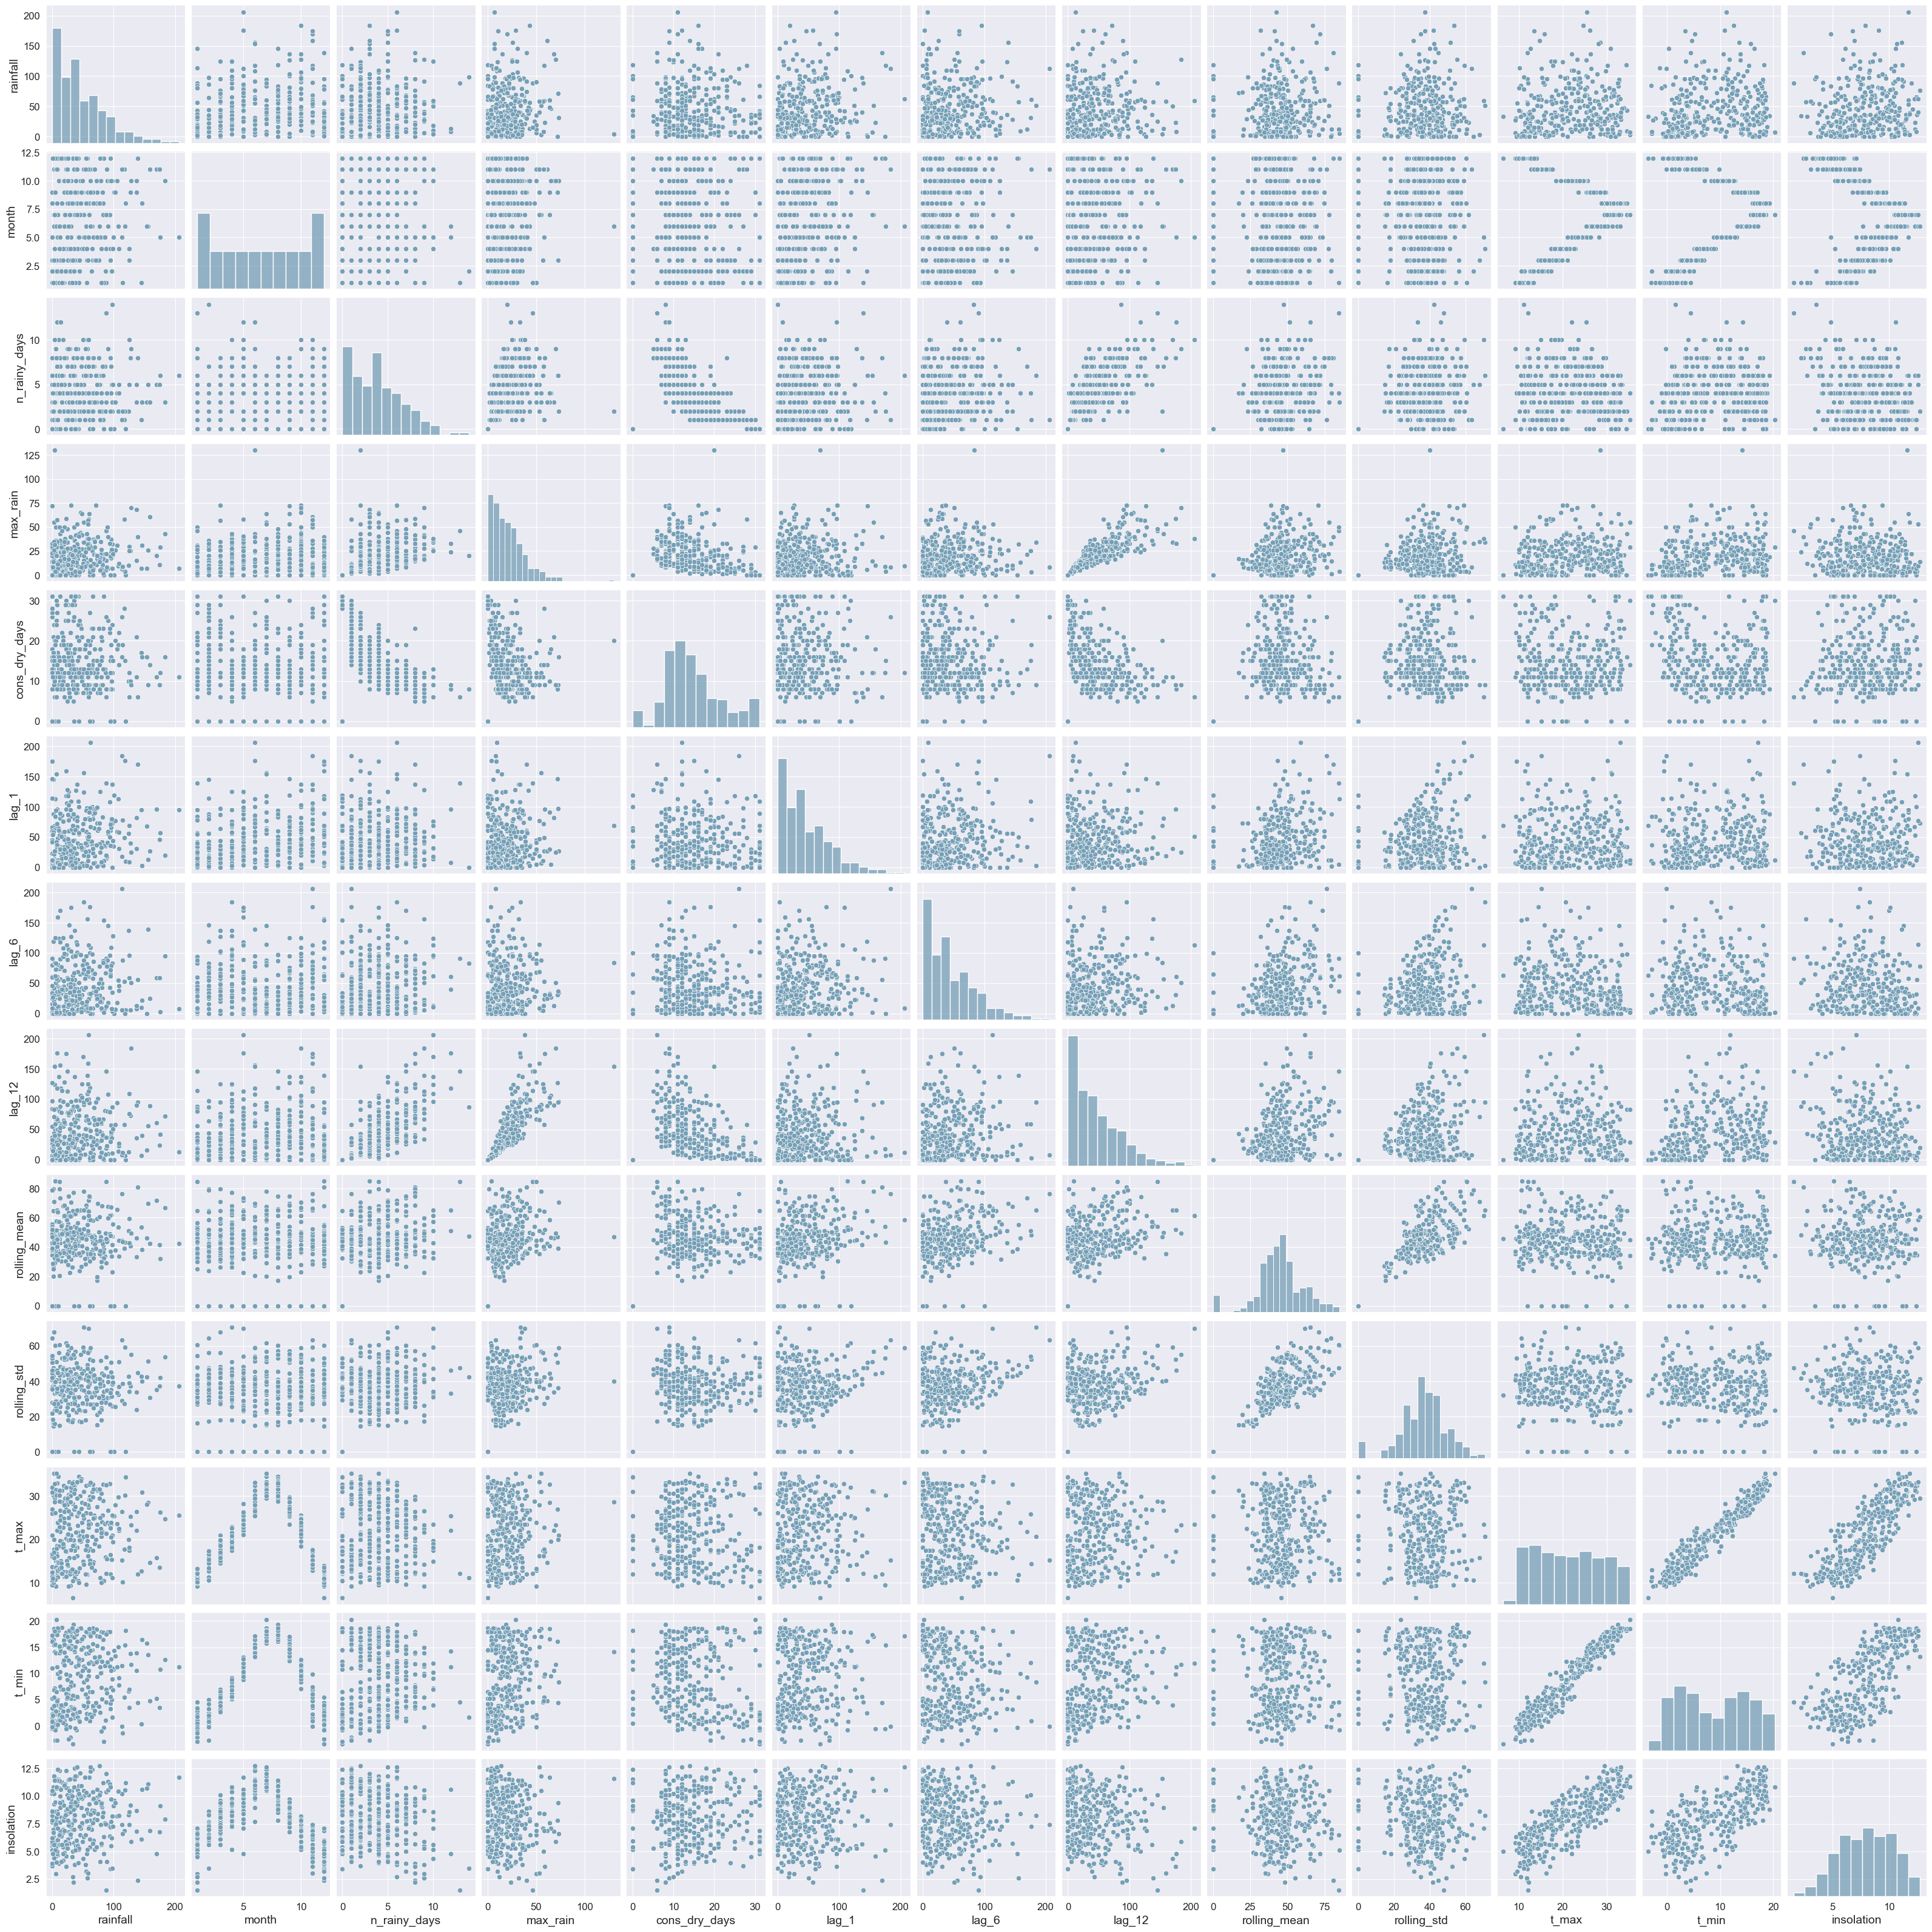

In [79]:
# scatterplots and distribution histograms
sns.pairplot(train)
plt.show()

There are no clear dependencies between rainfall amount and the added features.

Some features may be highly correlated with each other (multicollinearity), which can reduce model interpretability and negatively affect the performance of linear models.
Let's examine the correlation coefficients between the features.

In [80]:
# Phik correlation coefficients matrix
phik_overview = train.phik_matrix()

interval columns not set, guessing: ['rainfall', 'month', 'n_rainy_days', 'max_rain', 'cons_dry_days', 'lag_1', 'lag_6', 'lag_12', 'rolling_mean', 'rolling_std', 't_max', 't_min', 'insolation']


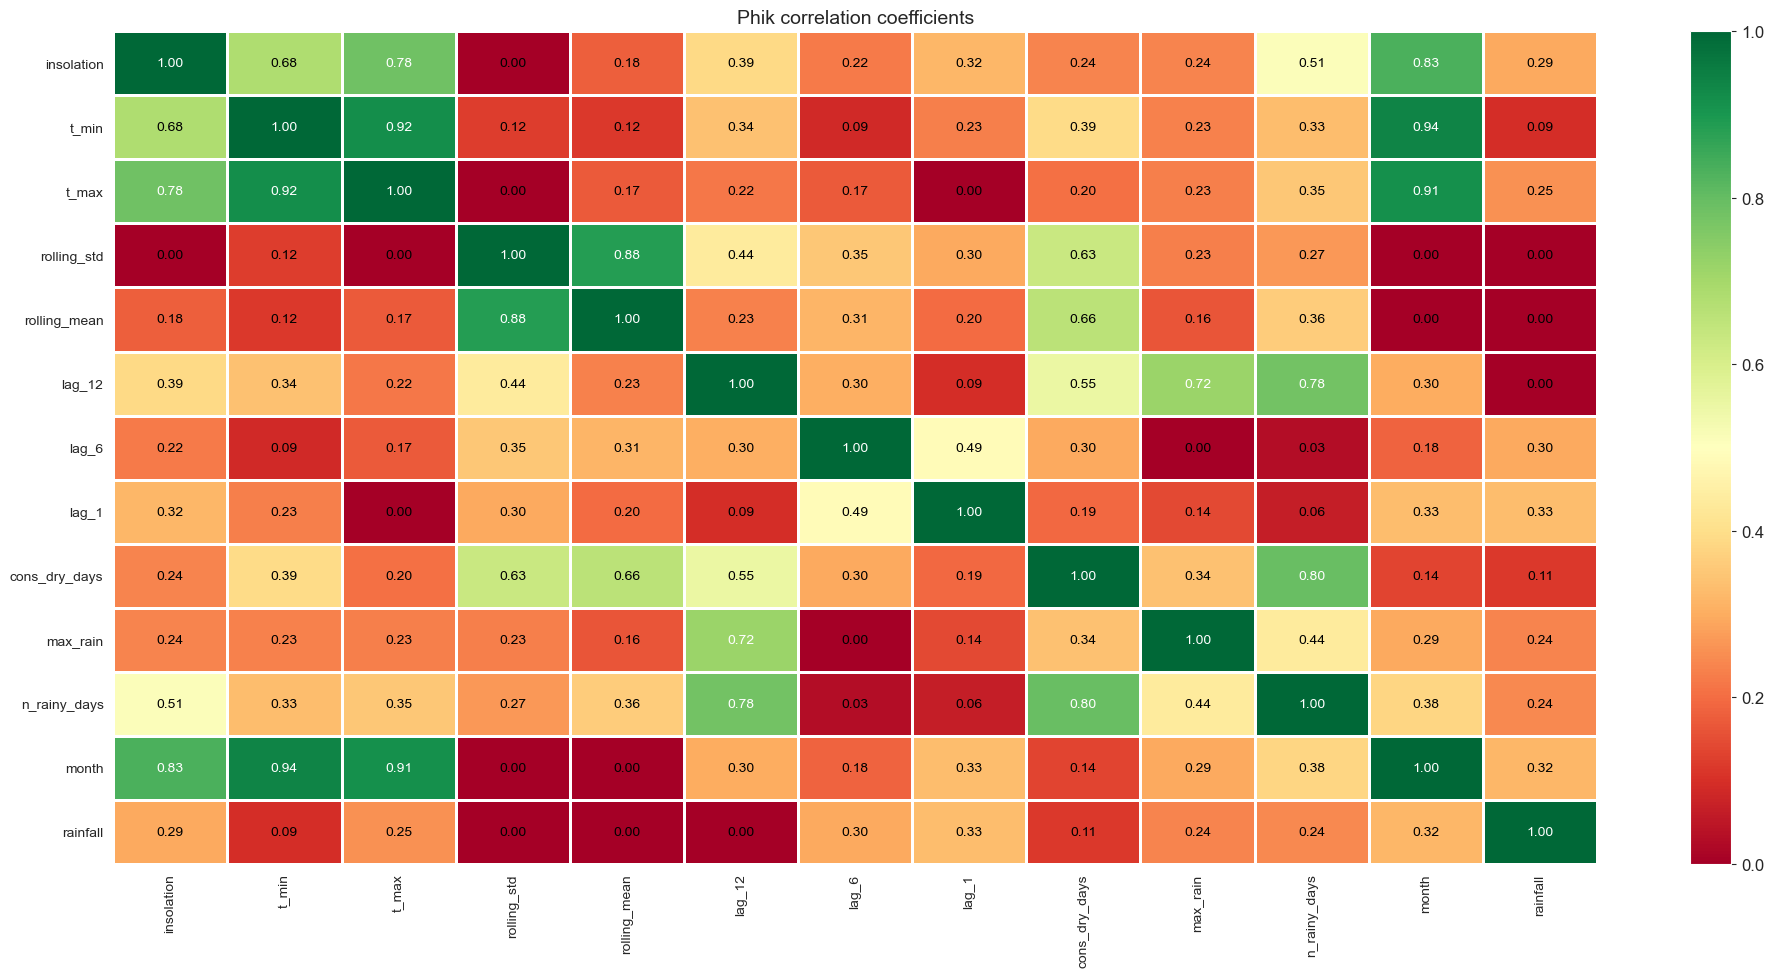

In [81]:
# plot Phik correlation coefficients matrix
plot_correlation_matrix(phik_overview.values, 
                        x_labels=('rainfall', 'month', 'n_rainy_days', 'max_rain', 'cons_dry_days', 'lag_1', 'lag_6', 'lag_12', 'rolling_mean', 'rolling_std', 't_max', 't_min', 'insolation'),
                        y_labels=('rainfall', 'month', 'n_rainy_days', 'max_rain', 'cons_dry_days', 'lag_1', 'lag_6', 'lag_12', 'rolling_mean', 'rolling_std', 't_max', 't_min', 'insolation'), 
                        title="Phik correlation coefficients", 
                        figsize=(20, 10),
                        vmin=0, vmax=1)

Rainfall does not show a significant correlation with any of the features.
Moderate correlations: 
- `lag_1` (0.33) and `lag_6` (0.30) suggest short-term memory effects in rainfalls, which may still be useful for time series models.
- `month` (0.32) indicates a moderate seasonal pattern, though not strongly pronounced.
- `insolation` (0.29)
Rainfall has little to no correlation with long-term lag features (`lag_12`), rolling statistics, or minimum temperature (`t_min`), indicating these may not be helpful predictors.

Inter-feature Correlations (Multicollinearity Risks)
- High correlations (> 0.7)
    - Seasonal and climatic variables: `month` is strongly correlated with `t_max`, `t_min`, and `insolation`, which is expected since temperature and solar radiation vary seasonally.
    - Rain-related features: `n_rainy_days` correlates highly with `lag_12` and `cons_dry_days`, implying redundant information; `max_rain` and `lag_12` correlation indicates that high rainfall in the same month of the previous year can be predictive of current extremes.
    - Rolling statistics: `rolling_mean` and `rolling_std` are strongly correlated, which is common since periods with higher averages often have more variability.
    - Temperature and insolation: `t_max`, `t_min`, and `insolation` are closely linked, reflecting their mutual dependence on seasonal changes.

For linear models, strong multicollinearity can be mitigated through regularization. 

### Auto-ARIMA with External Features

According to analysis of correlations let's use only several exogenous features.

In [80]:
# define external features
exo_features =  [
 'max_rain',
 'lag_6',
 'insolation'
]

In [81]:
# fit the SARIMAX model with the selected orders
# cross-validation
mae_list = []
for train_idx, val_idx in tscv.split(train):
    val_train, val_test = train.iloc[train_idx], train.iloc[val_idx]
    
    # fit SARIMA model on train set
    sarima_model = SARIMAX(val_train['rainfall'], 
                           exog=val_train[exo_features],
                           order=(0,0,1), 
                           seasonal_order=(1,0,1,12))
    
    result = sarima_model.fit(disp=False)
    
    # forecast validation period
    val_forecast = result.forecast(steps=len(val_test),
                                   exog=val_test[exo_features])

    val_forecast_tr = result.forecast(steps=len(val_train), 
                                      exog=val_train[exo_features])
    # compute MAE
    mae = mean_absolute_error(val_test['rainfall'], val_forecast)
    mae_tr = mean_absolute_error(val_train['rainfall'], val_forecast_tr)
    mae_list.append(mae)
    print(f'Fold MAE: {mae}, Train {mae_tr}')
    

# average MAE across folds
avg_mae = np.mean(mae_list)
sd_mae = np.std(mae_list)
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')

Fold MAE: 34.62497912958876, Train 39.6857063038415
Fold MAE: 27.14350901999999, Train 28.713757095629425
Fold MAE: 30.39608628851886, Train 28.783427223600032
Fold MAE: 29.424125506961577, Train 30.27212255160306
Fold MAE: 35.214098446003305, Train 29.257337440996476
Fold MAE: 28.31477655783878, Train 31.7320809926662
Fold MAE: 33.99389844454518, Train 30.87604817532017
Fold MAE: 25.939591567856937, Train 30.65518665569088
Average Cross-Validation MAE: 30.63, SD: 3.34


**Conclusion**:<br>
Adding external features to the SARIMAX model led to worse performance. External regressors can introduce complexity without providing meaningful predictive power. 
Probably we have irrelevant features: features that aren’t strongly predictive or are redundant can worsen forecasts. While `max_rain` and `insolation` are helpful, their limited correlation with `rainfall` may prevent notable improvements. `lag_6` features might overlap with SARIMA’s inherent capability to model autocorrelation.

**Next step**<br>
SARIMAX assumes that the relationship between the target and the external features is linear. Tree-based models (e.g., CatBoost, LightGBM) might extract non-linear relationships missed by SARIMA. SARIMAX does not inherently penalize complexity. We can try linear regression with regularization.

In [82]:
# characteristics for the pivot table
model_name.append('SARIMAX')
model_param.append('(0,0,1)(1,0,1)[12]')
models_forecast['sarimax'] = val_forecast
cv_mae.append(round(avg_mae, 2))
cv_sd.append(round(sd_mae, 2))

### Non-specific Time Series Models

Let's try linear regression with regularization, random forest and two gradient boosting models - CatBoost and LightGBM.

In [83]:
exo_f = [
 'month',
 'n_rainy_days',
 'max_rain',
 'cons_dry_days',
 'lag_1',
 'lag_6',
 'lag_12',
 'rolling_mean',
 'rolling_std',
 't_max',
 't_min',
 'insolation'
]

In [84]:
# target and features
y_train, y_test = train['rainfall'], test['rainfall']
#X_train, X_test = train.drop('rainfall', axis=1), test.drop('rainfall', axis=1)
X_train = train[exo_f]
X_test = test[exo_f]

X_train = X_train.fillna(0)

In [85]:
print('Train:', X_train.index.min(), ':', X_train.index.max())
print('Test:', y_test.index.min(), ':', y_test.index.max())

Train: 1995-01-01 00:00:00 : 2021-12-01 00:00:00
Test: 2022-01-01 00:00:00 : 2024-12-01 00:00:00


In [86]:
# create the pipeline
pipeline = Pipeline([('regr', DummyRegressor())])

In [87]:
# set grid search params
params = [
    {'regr': [ElasticNet(random_state=RANDOM_STATE)],
     'regr__l1_ratio': [0, 0.5, 1]},
    
    {'regr': [LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)],
     'regr__n_estimators': range(20, 200, 10),
     'regr__max_depth': range(4, 12),
     'regr__num_leaves': range(35, 150),
     'regr__learning_rate': [0.01, 0.1, 0.3]}, 
       
    {'regr': [CatBoostRegressor(random_state=RANDOM_STATE, silent=True)],
     'regr__n_estimators': range(20, 200),
     'regr__depth': [4, 6, 8, 10],
     'regr__learning_rate': [0.01, 0.1, 0.3],
     'regr__l2_leaf_reg': [0.2, 0.5, 1, 3]}]

In [88]:
# construct grid search
grid = RandomizedSearchCV(pipeline,
                          params,
                          cv=tscv,
                          verbose=False,
                          scoring='neg_mean_absolute_error',
                          n_jobs=-1,
                          random_state=RANDOM_STATE)

In [89]:
# fit the grid search object
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
                   estimator=Pipeline(steps=[('regr', DummyRegressor())]),
                   n_jobs=-1,
                   param_distributions=[{'regr': [ElasticNet(random_state=42)],
                                         'regr__l1_ratio': [0, 0.5, 1]},
                                        {'regr': [LGBMRegressor(random_state=42,
                                                                verbose=-1)],
                                         'regr__learning_rate': [0.01, 0.1,
                                                                 0.3],
                                         'regr__max_depth': range(4, 12),
                                         'regr__n_estimators': range(20, 200, 10),
                                         'regr__num_leaves': range(35, 150)},
                                        {'regr': [<catboost.core.CatBoostRegressor object at 0x156e7bd90>],
                                         'regr__depth': [4, 6, 8, 10],
                                         'regr__l2_leaf_reg': [0.2, 0.5, 1, 3],
                                         'regr__learning_rate': [0.01, 0.1,
                                                                 0.3],
                                         'regr__n_estimators': range(20, 200)}],
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=False)

In [90]:
# hyperparameters of the best model
print('Hyperparameters of the best model:')
grid.best_params_

Hyperparameters of the best model:


{'regr__num_leaves': 72,
 'regr__n_estimators': 130,
 'regr__max_depth': 11,
 'regr__learning_rate': 0.01,
 'regr': LGBMRegressor(random_state=42, verbose=-1)}

In [91]:
train_pr = grid.predict(X_train)
mean_absolute_error(y_train, train_pr)

25.041697844429002

In [92]:
test_pr = grid.predict(X_test)
mean_absolute_error(y_test, test_pr)

30.244812352408726

In [93]:
# MAE
avg_mae = abs(grid.best_score_)

# STD
sd_mae = grid.cv_results_['std_test_score'][grid.best_index_]

print(f'\nMean monthly rainfall amount: {train["rainfall"].mean():.2f}')
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')


Mean monthly rainfall amount: 46.58
Average Cross-Validation MAE: 30.98, SD: 4.10


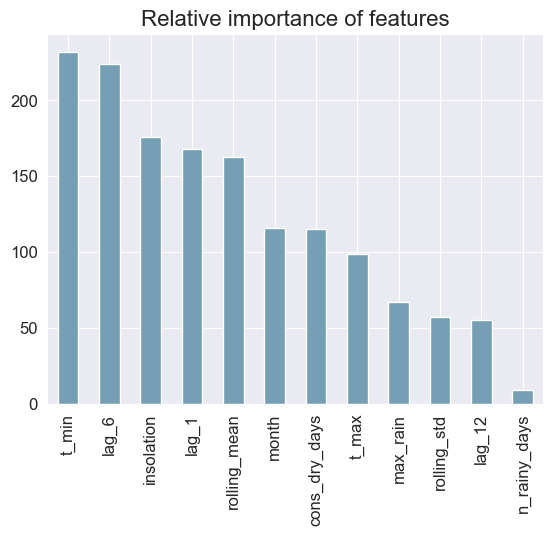

In [94]:
# Importance of the features for best model
feature_importances = pd.DataFrame(
    {'features': list(X_train),
     'feature_importance': grid.best_estimator_.named_steps['regr'].feature_importances_})

# plot feature importances
feature_importances.sort_values(by='feature_importance', ascending=False).plot(kind='bar', x='features', legend=None)
plt.title('Relative importance of features')
plt.xlabel(None)
plt.show()

In [95]:
# get last CV fold
for train_idx, val_idx in tscv.split(X_train):
    val_train, val_test = X_train.iloc[train_idx], X_train.iloc[val_idx]

In [96]:
# make predictions on the last CV fold
val_forecast = grid.predict(val_test)

In [97]:
# characteristics for the pivot table
model_name.append('LGBMRegressor')
model_param.append('num_leaves: 72, n_estimators: 130, max_depth: 11, learning_rate: 0.01')
models_forecast['lgbm'] = val_forecast
cv_mae.append(round(avg_mae, 2))
cv_sd.append(round(sd_mae, 2))

Even with ElasticNet, CatBoost, and LightGBM and an extensive feature set, the Average Cross-Validation MAE: 30.98 (SD: 4.10) is still comparable to SARIMA (without features) and SARIMAX (with reduced features). 
- rainfall might be inherently difficult to predict from the provided features
- high variability in rainfall can limit improvements regardless of model complexity
- ML models may not inherently capture temporal dependencies as effectively as SARIMA

### Comparison of Models

In [98]:
# DataFrame with all characteristics
tbl = pd.DataFrame(
    {'Model': model_name,
     'Parameters': model_param,
     'MAE': cv_mae,
     'STD': cv_sd
    })
tbl.sort_values(by='MAE', ascending=True)

Model                                         Parameters    MAE  \
2      Auto-ARIMA                                 (0,0,1)(1,0,1)[12]  29.35   
3         Prophet                            yearly_seasonality, mul  29.72   
4         SARIMAX                                 (0,0,1)(1,0,1)[12]  30.63   
0  Constant model                                   median per month  30.68   
5   LGBMRegressor  num_leaves: 72, n_estimators: 130, max_depth: ...  30.98   
1          SARIMA                                 (1,0,1)(1,1,1)[12]  32.80   

    STD  
2  3.38  
3  3.44  
4  3.34  
0  4.16  
5  4.10  
1  7.88

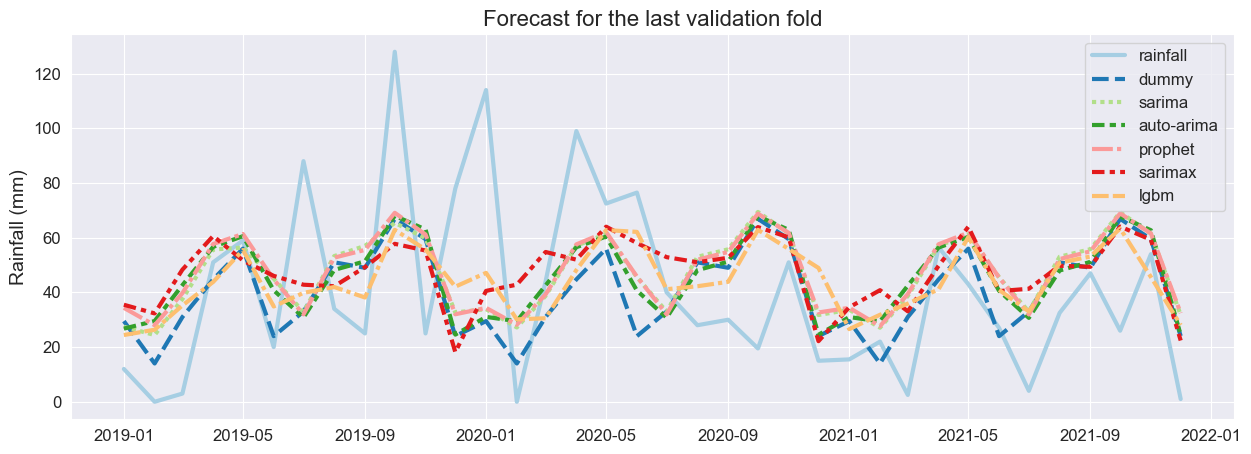

In [115]:
# plot predictions
plt.figure(figsize=(15,5))
sns.lineplot(models_forecast, palette='Paired', linewidth = 3)
plt.title('Forecast for the last validation fold')
plt.ylabel('Rainfall (mm)')
plt.xlabel(None)
plt.legend()
plt.show()

All models show similar performance, with inaccuracies at the 'peaks' of the time series. Prophet and SARIMA yield very similar results. Auto-ARIMA, which automatically selects the best model parameters, has the smallest standard deviation (SD) and performs slightly better than the Constant model. Therefore, we will use Auto-ARIMA for forecasting monthly rainfall.

## Testing

In [93]:
# train-test split, 10% as test set
train, test = train_test_split(df_month, test_size=0.1, shuffle=False)

In [94]:
# fit SARIMA model on all train set
sarima_model = SARIMAX(train['rainfall'],
                       order=(0,0,1), 
                       seasonal_order=(1,0,1,12))
    
result = sarima_model.fit(disp=False)
    
# forecast test period
forecast = result.forecast(steps=len(test))
    
# compute MAE
mae = mean_absolute_error(test['rainfall'], forecast)

print(f'Test MAE: {mae:.2f}')

Test MAE: 29.19


In [96]:
# forecast test period
forecast_tr = result.forecast(steps=len(train))
    
# compute MAE
mae_tr = mean_absolute_error(train['rainfall'], forecast_tr)

print(f'Test MAE: {mae_tr:.2f}')

Test MAE: 28.63


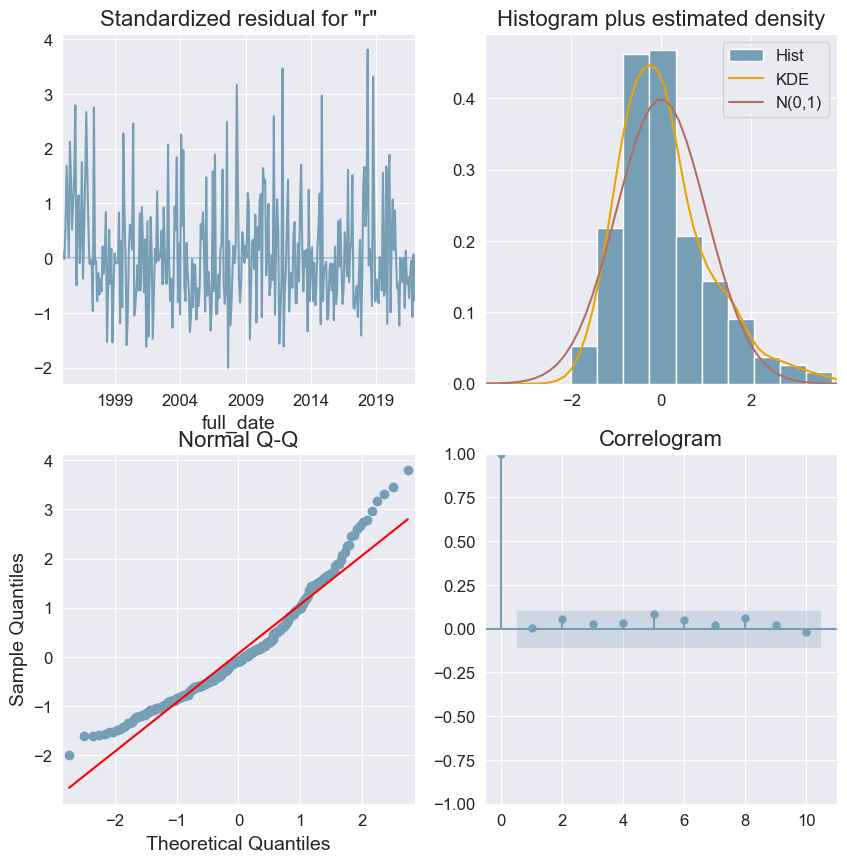

In [106]:
# plot diagnostics
result.plot_diagnostics(figsize=(10,10))
plt.show()

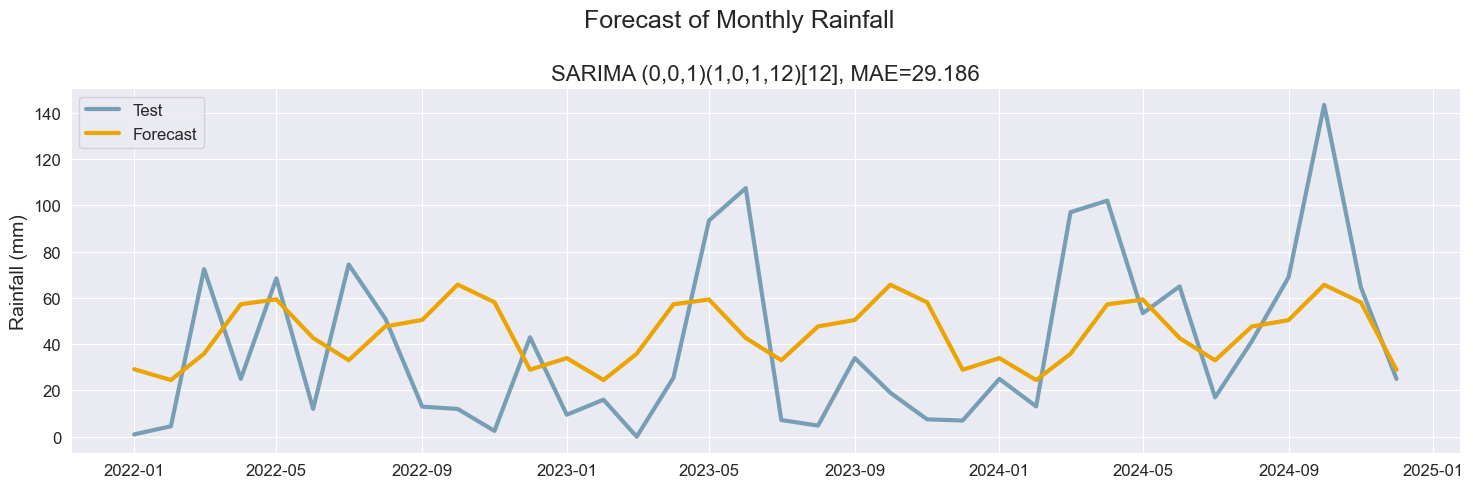

In [108]:
# plot test and predicted data
plt.figure(figsize=(15, 5))
plt.plot(test, linewidth = 3)
plt.plot(forecast, linewidth = 3)
plt.suptitle('Forecast of Monthly Rainfall')
plt.title(f'SARIMA (0,0,1)(1,0,1,12)[12], MAE={mae:.3f}')
plt.ylabel('Rainfall (mm)')
plt.legend(['Test', 'Forecast'], 
           loc='upper left')
plt.tight_layout()
plt.show()

The model is systematically inaccurate at the "peaks" - at the maximums below, and at the minimums above the correct values. For a more accurate forecast, the model should be improved.

## Forecast for 2025

Because we decided to use SARIMA without exogenous features, we can make forecasts for the entire year 2025. SARIMA is a univariate model based on past data, the prediction horizon is theoretically as far out as the number of future periods we want to forecast, but the accuracy of the forecast decreases as the forecast horizon increases.

In [109]:
# fit SARIMA model on all train set
sarima_model = SARIMAX(df_month['rainfall'],
                       order=(0,0,1), 
                       seasonal_order=(1,0,1,12))
    
result_2025 = sarima_model.fit(disp=False)
    
# forecast test period
forecast_2025 = result_2025.forecast(steps=12)

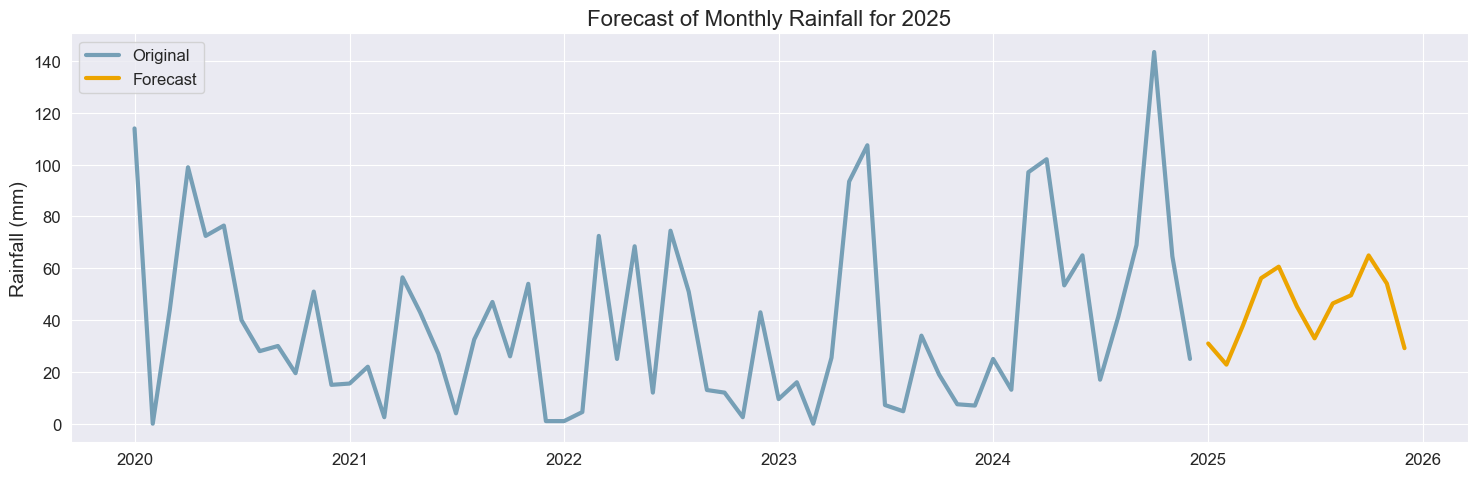

In [110]:
# plot test and predicted data
plt.figure(figsize=(15, 5))
plt.plot(df_month['2020':'2024'], linewidth = 3)
plt.plot(forecast_2025, linewidth = 3)
plt.title('Forecast of Monthly Rainfall for 2025')
plt.ylabel('Rainfall (mm)')
plt.legend(['Original', 'Forecast'], 
           loc='upper left')
plt.tight_layout()
plt.show()

In [111]:
forecast_2025

2025-01-01    30.958770
2025-02-01    22.813675
2025-03-01    37.873111
2025-04-01    56.180546
2025-05-01    60.620934
2025-06-01    45.218971
2025-07-01    32.959490
2025-08-01    46.440475
2025-09-01    49.574613
2025-10-01    64.962221
2025-11-01    54.099723
2025-12-01    29.165267
Freq: MS, Name: predicted_mean, dtype: float64

## Conclusion
In this project, we explored and compared multiple models for predicting monthly rainfall amounts using a range of features and external regressors. The steps and findings are summarized below:

1. Models Tested:

We evaluated a variety of models, both simple and complex, to forecast the target variable (monthly rainfall). These models included:
1) Constant Model: A baseline model where we forecasted the median value for each month based on historical data.
2) SARIMA: A classical seasonal ARIMA model with manually specified parameters (SARIMA(1,0,1)(1,1,1)[12]) and Auto-ARIMA, which automatically selects the best model parameters.
3) Prophet: A model designed for time series forecasting with seasonality and holiday effects.
4) CatBoost and LGBMRegressor: A gradient boosting models capable of handling large datasets and nonlinear relationships.
5) SARIMAX: An extension of the SARIMA model that includes external regressors (exogenous variables), which we incorporated to improve model performance.

2. Feature Engineering:

Several features were created and tested to improve model accuracy, such as:
- Temporal Features: month, n_rainy_days, max_rain, cons_dry_days, etc., aimed at capturing seasonal trends and weather patterns.
- Lagged Features: Lagged rainfall values (e.g., previous months) and rolling averages to help capture temporal dependencies in the data.
- External Features: External data like monthly temperature (t_max, t_min) and solar insolation (insolation) from the Manresa dataset were used to capture broader environmental influences.

3. Cross-Validation:

To assess model performance, cross-validation was conducted using a time-series split (chronological order). The models were evaluated based on Mean Absolute Error (MAE) and Standard Deviation (STD) across the validation folds. **Auto-ARIMA** emerged as the best-performing model, with the lowest MAE and a reasonable STD. SARIMA with manually set parameters performed poorly due to high variance, indicating that model selection plays a crucial role.

4. Test Set Evaluation:

After finalizing the model choice, we tested the best model (Auto-ARIMA) on the test set. The test set **MAE was 29.19**, which is slightly lower than the cross-validation MAE, indicating that the model generalizes well.

5. Insights and Conclusion:

External Features: While adding external features such as temperature, insolation, and lagged rainfall improved the model's interpretability and allowed us to assess seasonality patterns, they did not significantly improve performance in this case. This suggests that the relationship between rainfall and these features is not strong enough to offer substantial improvements for this dataset.

Model Performance: The difference in MAE between the Auto-ARIMA, SARIMAX and Constant Model was marginal, suggesting that external features and temporal lags may have had a limited impact in this particular case. However, Auto-ARIMA provided a slight improvement in the overall performance, which is significant when making forecasts for long-term planning

**Future Work**:

- Feature Selection & Engineering: Further feature selection and engineering could help refine the model.
- Model Tuning: Hyperparameter tuning using GridSearchCV or RandomizedSearchCV could be applied to SARIMAX and other models to optimize the model further.
- Other Models: Other machine learning techniques could be explored to capture non-linear patterns better.
- Validation Techniques: Expanding cross-validation techniques or using walk-forward validation can help improve model generalization and better assess performance over time.